In [72]:
%matplotlib inline
import numpy as np, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

In [73]:
x, sr = librosa.load('./24chords/C#.wav')
print(sr)
ipd.Audio(x, rate=sr)

22050


In [74]:
hop_length = 512

# 1. Chroma
A chroma vector (Wikipedia) (FMP, p. 123) is a typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, ..., B}, is present in the signal.

[librosa.feature.chroma_sfst](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html#librosa.feature.chroma_stft)

[librosa.feature.chroma_cqt](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html#librosa.feature.chroma_cqt)

[librosa.feature.chroma_cens](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html#librosa.feature.chroma_cens)

Chroma energy normalized statistics (CENS) (FMP, p. 375). The main idea of CENS features is that taking statistics over large windows smooths local deviations in tempo, articulation, and musical ornaments such as trills and arpeggiated chords. CENS are best used for tasks such as audio matching and similarity.



## Comparing stft, chroma_stft, chroma_cqt and chroma_cens (Librosa Library)
Conclusion: Cens feature is very useful (eg C# major -> C#, F, G#)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/librosa/display.py:725: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


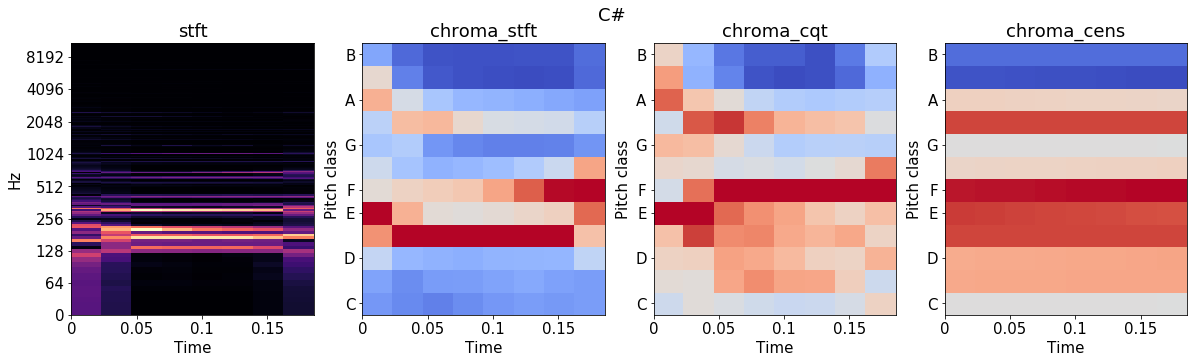

In [79]:
plt.figure(figsize=(20, 5))
plt.rc('font', size=15)
hop_length = 512

x, sr = librosa.load('./24chords/C#.wav')

stft = librosa.stft(x)
chroma_stft = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
chroma_cqt = librosa.feature.chroma_cqt(x, sr=sr, hop_length=hop_length)
chroma_cens = librosa.feature.chroma_cens(x, sr=sr, hop_length=hop_length)

plt.subplot(1, 4, 1)
plt.title('stft')
librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='log',)

plt.subplot(1, 4, 2)
plt.title('chroma_stft')
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

plt.subplot(1, 4, 3)
plt.title('chroma_cqt')
librosa.display.specshow(chroma_cqt, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

plt.subplot(1, 4, 4)
plt.title('chroma_cens')
librosa.display.specshow(chroma_cens, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

plt.suptitle('C#')
plt.show()

## 1c. Does it work well for all chords?
Yes, pretty good mapping of notes

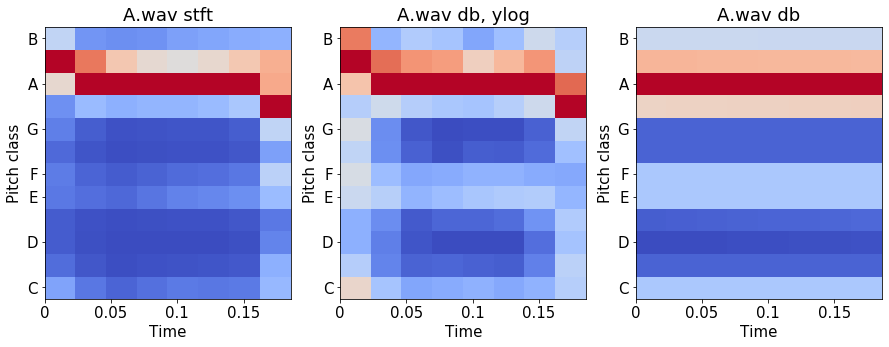

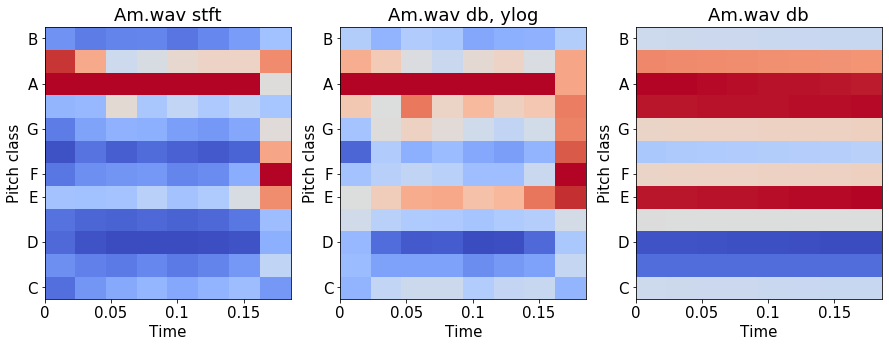

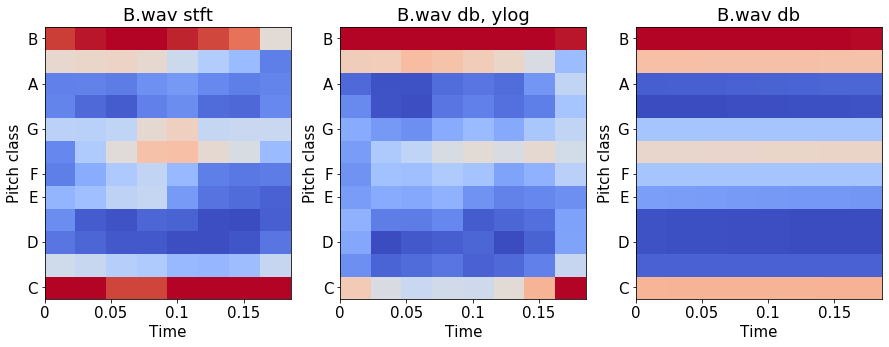

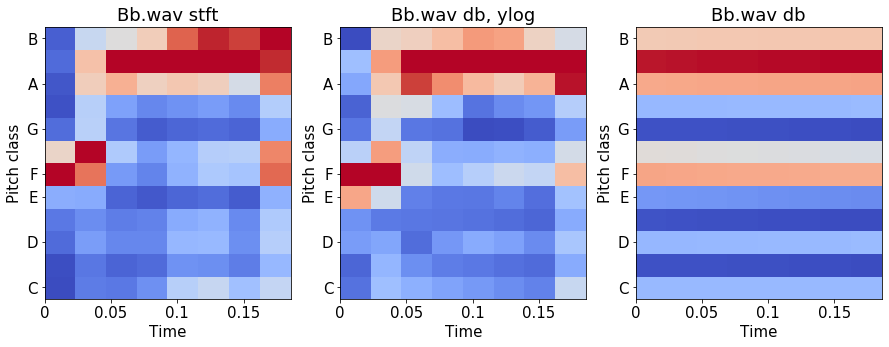

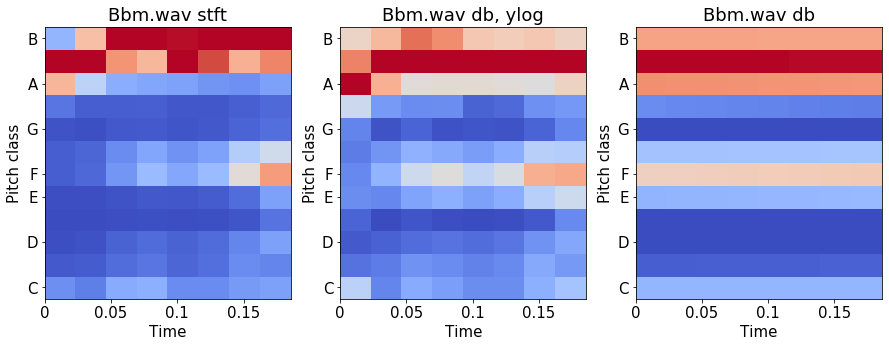

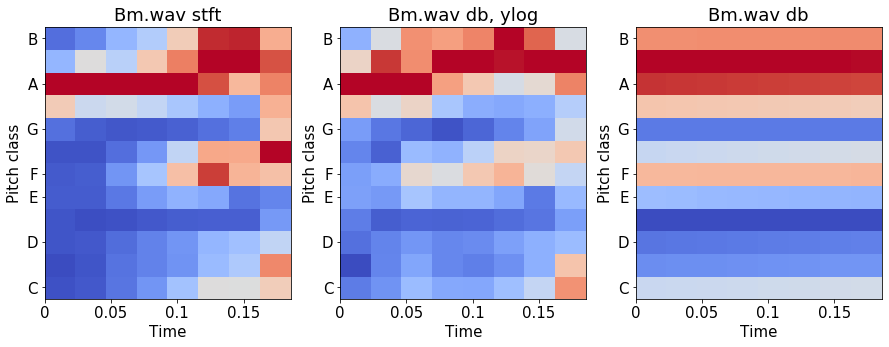

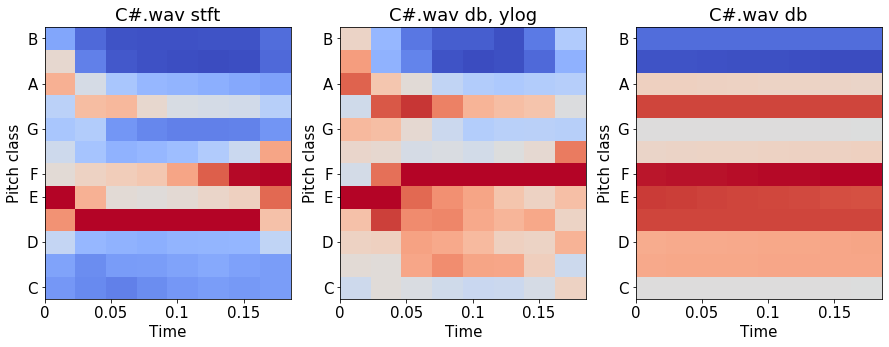

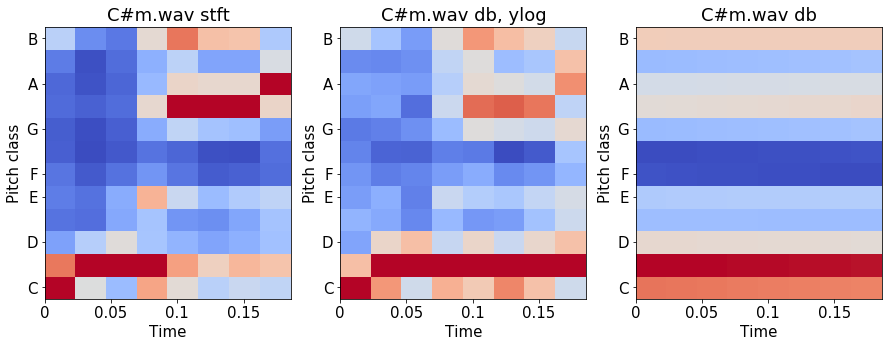

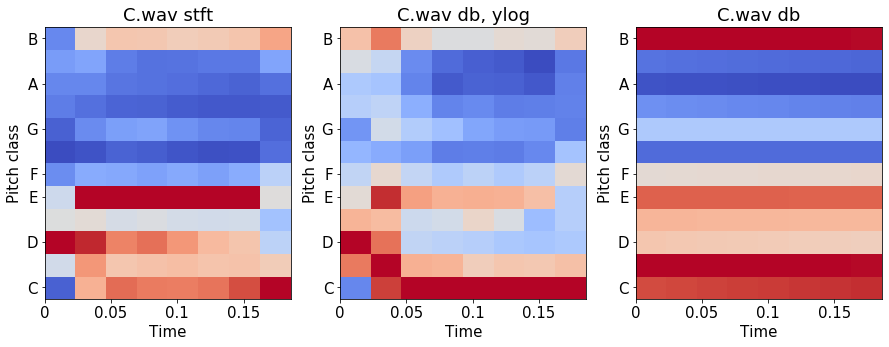

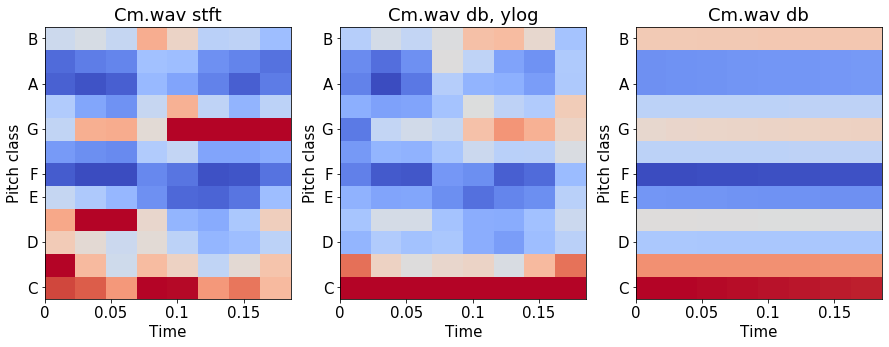

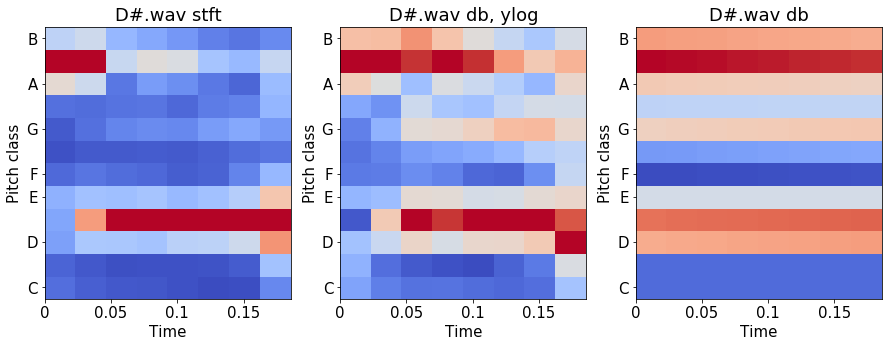

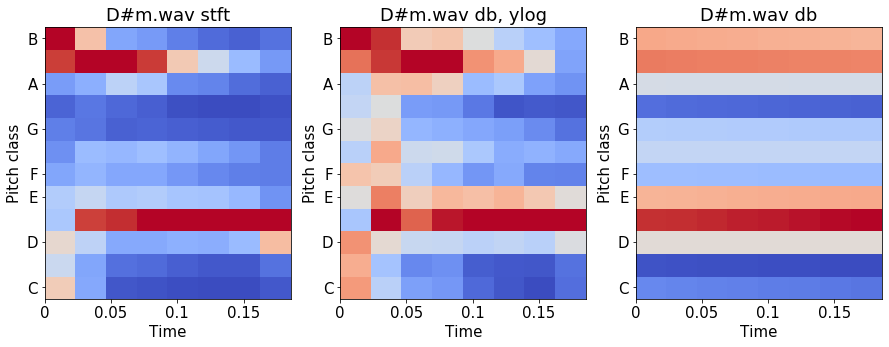

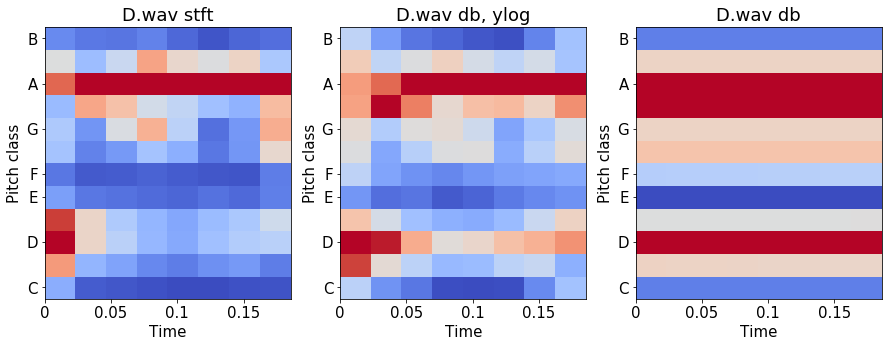

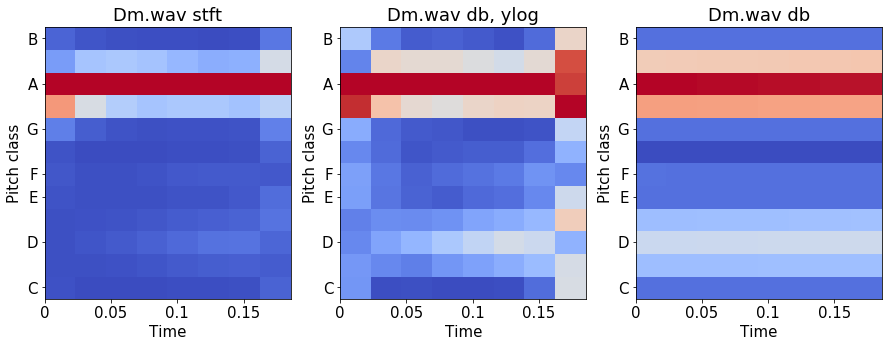

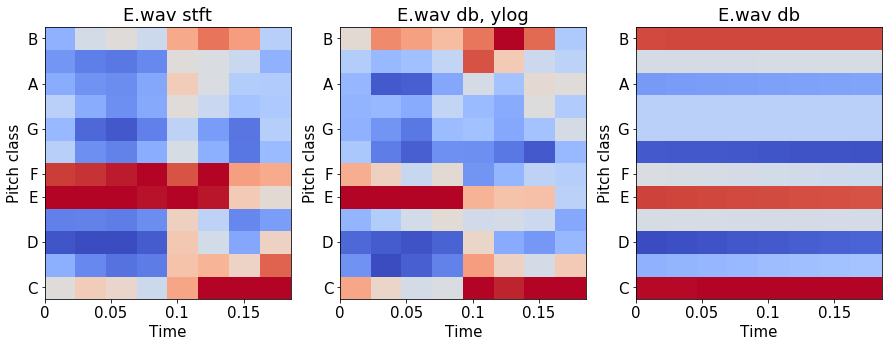

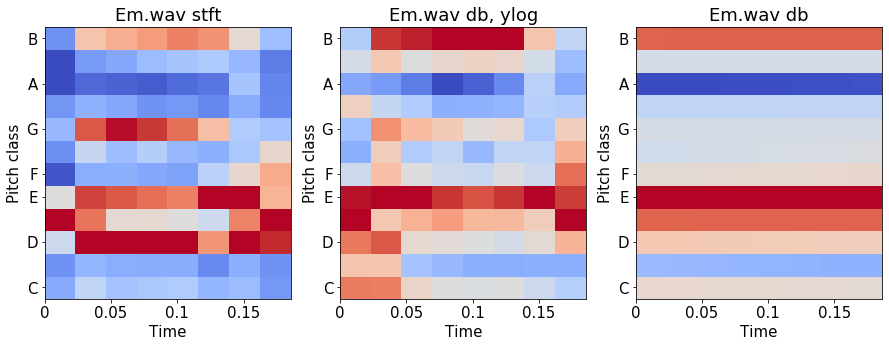

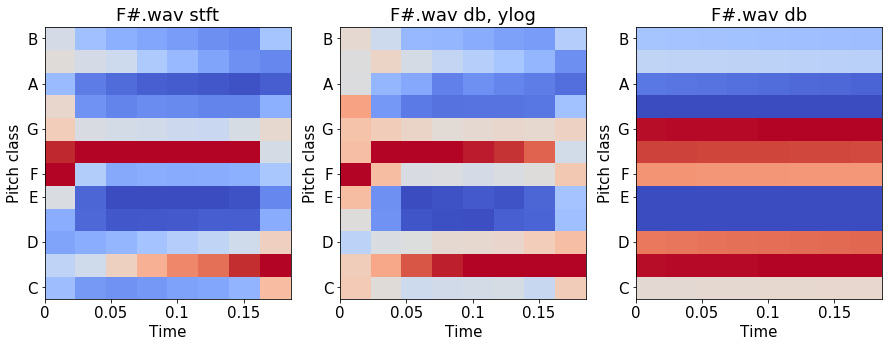

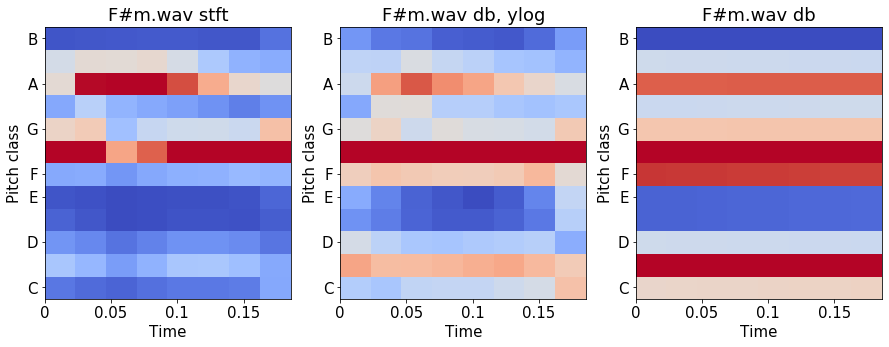

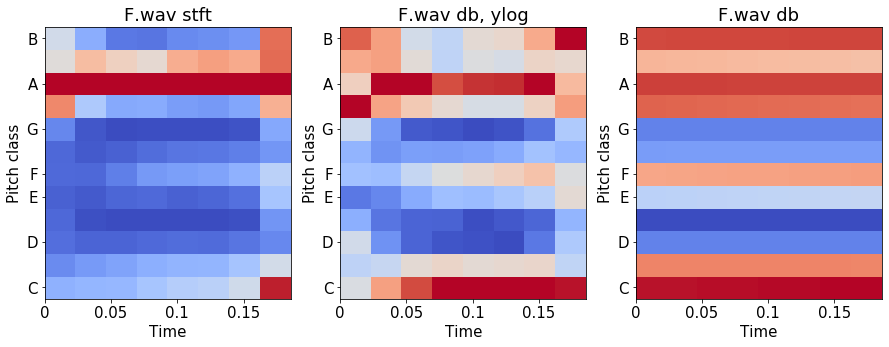

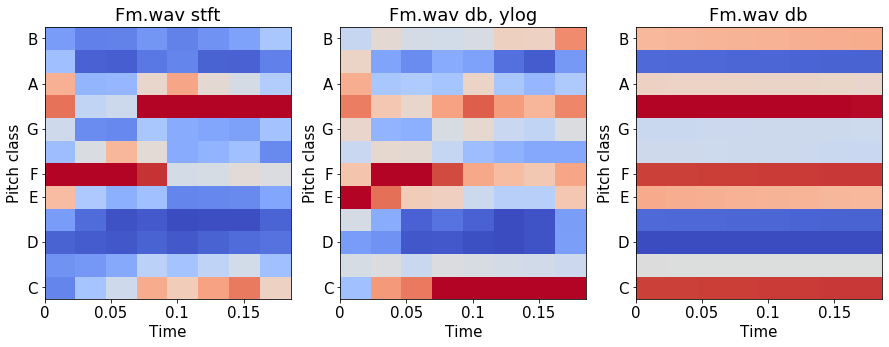

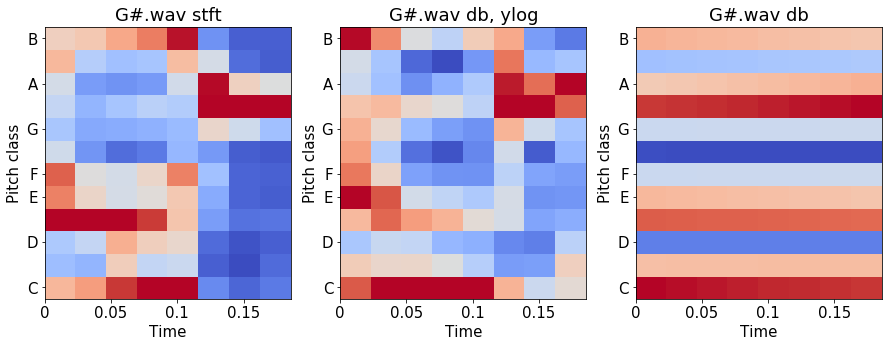

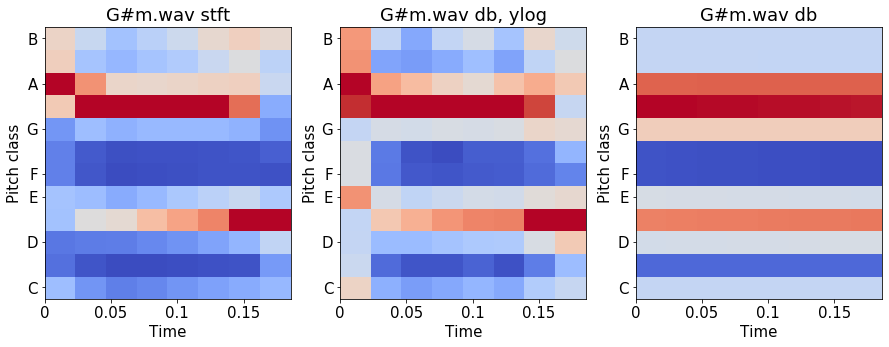

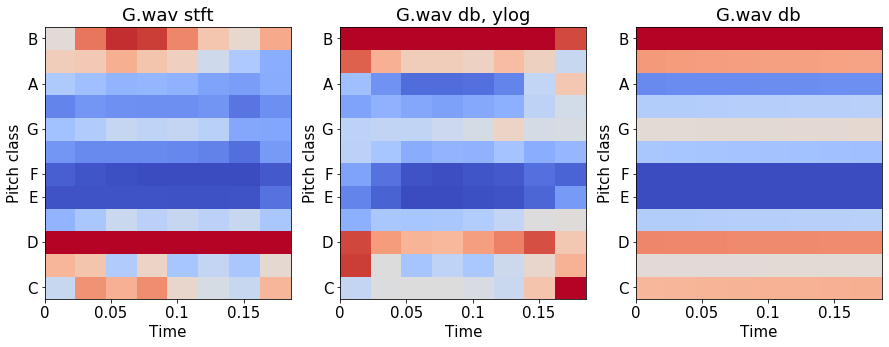

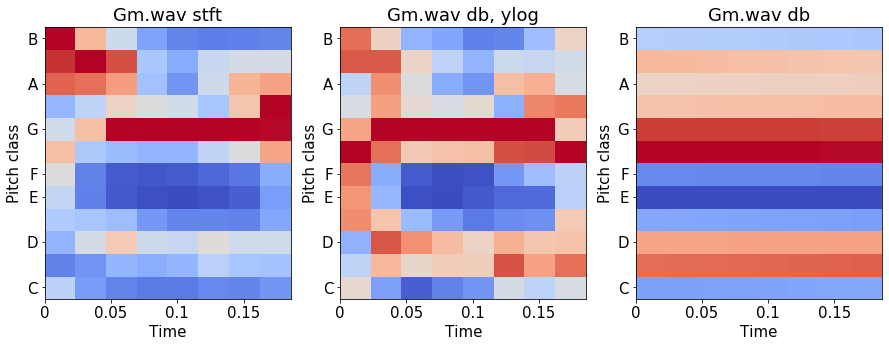

In [80]:
import os
path = './24chords/'
files = list(os.listdir(path))
files.sort()

for i in range(len(files)):
    plt.figure(figsize=(15, 5))
    x, sr = librosa.load('./24chords/{}'.format(files[i]))

    stft = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
    cqt = librosa.feature.chroma_cqt(x, sr=sr, hop_length=hop_length)
    cens = librosa.feature.chroma_cens(x, sr=sr, hop_length=hop_length)

    plt.subplot(1, 3, 1)
    plt.title('{} stft'.format(files[i]))
    librosa.display.specshow(stft, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

    plt.subplot(1, 3, 2)
    plt.title('{} db, ylog'.format(files[i]))
    librosa.display.specshow(cqt, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

    plt.subplot(1, 3, 3)
    plt.title('{} db'.format(files[i]))
    librosa.display.specshow(cens, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

    plt.show()

## 1d. What is the chroma_cens array? Bb
Conclusion: array where rows represents notes in chordagram (bottom to top). ie row0 = C, row1 = C#...
Columns are units of time (x axis)

Since our samples are short, for our calculations we can remove the time dimension to get a (12,) vector representing 12 notes. We do this by averaging across the rows.
But note that to display the chromagram with Librosa, it needs the full array

(12, 8)


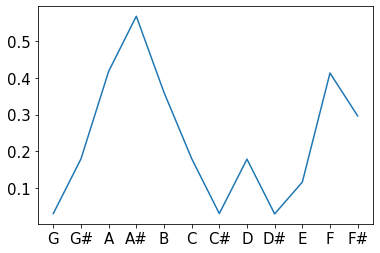

In [109]:
import numpy as np
x, sr = librosa.load('./24chords/Bb.wav')
chroma_cens = librosa.feature.chroma_cens(x, sr=sr, hop_length=hop_length)
print(chroma_cens.shape)
chroma_cens = np.mean(chroma_cens,axis=1)
chroma_cens = np.roll(chroma_cens, 5) 

plt.plot(chroma_cens)
notes = ['G','G#','A','A#','B','C','C#','D','D#','E','F','F#']
plt.xticks(np.arange(12),notes)
plt.show()

# 2. Let's use the audio-to-chroma feature extraction in our model!

## Here's what hasn't worked:

### Try 1: Preprocess outside the model
Preprocess the training samples outside the model (8160,) -> (12,) then train the model. Super accurate, 0.99% in < 10 epochs

Problem: Works well in training, but then from mobile devices we'll need to preprocess the audio before feeding it into the model. ie implement the chroma_cens in android and iOS which I dont quite wanna do

Better idea: Include the preprocessing step IN the model as a custom layer

### Try 2:  Custom Feature extraction layer in Keras Model with Librosa
Use the Librosa Library in the model as a custom keras layer.

Problem: Tensor to Numpy conversion errors. 

See the bottom "[Archived] Failed Models" in https://oslyn-le-v1.notebook.ca-central-1.sagemaker.aws/notebooks/oslyn-LE/Live-model-v4/Live%20model-v4.ipynb

### Try 3: Generate chromas without Librosa library - "Long CQT" - Compared with Librosa 
Generate chromagrams without Librosa, to have more flexibility to modify numpy/tensor operations
Compared with to confirm that it generates similar chromagrams.

Problem: runs into the same eager execution/ numpy-tensor / model saving problem as above, and the code is too long and complex I dont want to debug it 

See "[Archived] Try 3: Generate chromas without Librosa library" at the end of this notebook

### Try 4: Short CQT - CURRENT HOPE. MODEL CAN TRAIN, SAVE. But not giving the right chromagrams

Rabbit holes that have been solved:
 - need to convert scipy operations to tensor operations to avoid the error in Try 2, Try 3
 - Solution: Rewrite parts in tf operations, resulting in next error
 
 - scipy.fftpack.fft and tensor.signal.fft dont give the same result?!?! Already manually added zero padding to tensor
 - Solution: changed fmin fmax range to A2 (110Hz) to A6 (1760Hz). Reduced the dimensions and padding required, giving more similar results
 
 - Final check: Yes it extracts out the right notes for each chord, similar results to Librosa and Long CQT

# Try 4: "short CQT" algorithm without library
adapted from https://github.com/orchidas/Chord-Recognition/blob/master/chromagram.py

Todo: Probably can convert the np operations in CQT_fast to tensor operations
but it's working for now

In [219]:
"""
Algorithm based on the paper 'Automatic Chord Recognition from
Audio Using Enhanced Pitch Class Profile' by Kyogu Lee
This script computes 12 dimensional chromagram for chord detection
@author ORCHISAMA
"""

from __future__ import division
from scipy.signal import hamming
from scipy.fftpack import fft
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def nearestPow2(inp):
    power = np.ceil(np.log2(inp))
    return 2**power


"""Function to compute CQT using sparse matrix multiplication, Brown and Puckette 1992- fast"""	
def CQT_fast(x,fs,bins,fmin,fmax,M, mode='tensor'):
    threshold = 0.0054 #for Hamming window
    K = int(bins*np.ceil(np.log2(fmax/fmin)))
    Q = 1/(2**(1/bins)-1)
    nfft = np.int32(nearestPow2(np.ceil(Q*fs/fmin)))
    tempKernel = np.zeros(nfft, dtype = np.complex)
    specKernel = np.zeros(nfft, dtype = np.complex)
    sparKernel = []

    #create sparse Kernel 
    for k in range(K-1,-1,-1):
        fk = (2**(k/bins))*fmin
        N = np.int32(np.round((Q*fs)/fk))
        tempKernel[:N] = hamming(N)/N * np.exp(-2*np.pi*1j*Q*np.arange(N)/N)
        specKernel = fft(tempKernel)
        specKernel[np.where(np.abs(specKernel) <= threshold)] = 0
        if k == K-1:
            sparKernel = specKernel
        else:
            sparKernel = np.vstack((specKernel, sparKernel))

    sparKernel = np.transpose(np.conjugate(sparKernel))/nfft
    
    if mode=='tensor':
        sparKernel = tf.convert_to_tensor(sparKernel, dtype=tf.complex64)
        x = tf.cast(x, tf.complex64)
        padding = tf.constant([[16, 16]], ) # 4112 = (nfft - x.shape[0])/2
        x = tf.pad(x, padding)
        ft = tf.signal.fft(x)
        cqt = tf.tensordot(ft, sparKernel,axes=1)
    else: #'scipy'
        ft = fft(x, nfft) # nfft
        cqt = np.dot(ft, sparKernel)
    return cqt

"""Function to compute Pitch Class Profile from constant Q transform"""
def PCP(cqt,bins,M):
    reshaped = tf.reshape(cqt, [-1, bins])
    return tf.reduce_sum(reshaped, 0) # sum column wise
##    NUMPY CODE
#     CH = np.zeros(bins)
#     for b in range(bins):
#         CH[b] = np.sum(cqt[b + (np.arange(M)*bins)])
#     return CH

def compute_chroma(x,fs, mode='tensor'):
    fmin = 110 # A2
    fmax = 1760 # A6
    bins = 12
    M = 1
    nOctave = np.int32(np.ceil(np.log2(fmax/fmin)))
    CH = np.zeros(bins)
    #Compute constant Q transform
    if mode=='tensor':
        cqt_fast = CQT_fast(x,fs,bins,fmin,fmax,M,mode='tensor')
    else: # 'scipy'
        cqt_fast = CQT_fast(x,fs,bins,fmin,fmax,M,mode='scipy')
    #get Pitch Class Profile
    CH = PCP(np.absolute(cqt_fast), bins, nOctave)
    return CH

## Compare for 1 chord (Bbm) 
Left: short CQT with scipy.fftpack.fft
Middle: short CQT with tf.signal.fft -> THE ONE WE'LL USE!
Right: Librosa Library

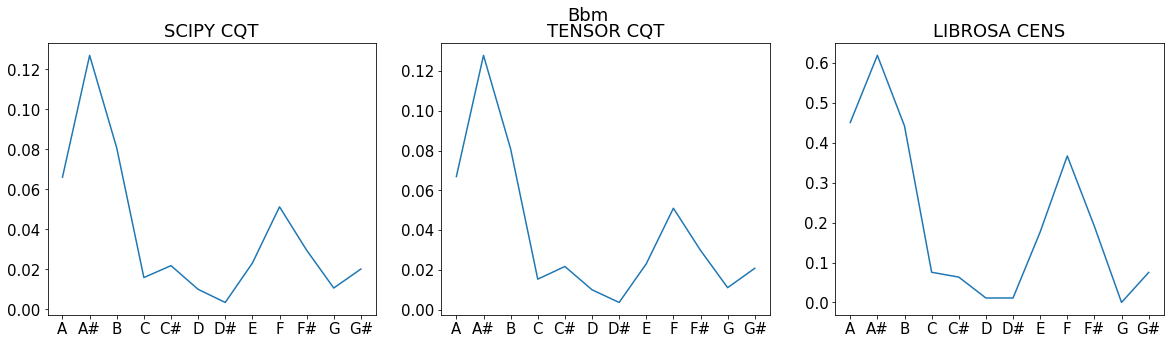

In [220]:
x, sample_rate = librosa.load('./24chords/Bbm.wav', sr=None)
notes = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    
plt.figure(figsize=(20, 5))
plt.suptitle('Bbm')

### FAST SCIPY CQT ###
chroma = compute_chroma(x, sample_rate, mode='scipy')
plt.subplot(1, 3, 1)
plt.xticks(np.arange(12),notes)
plt.title('SCIPY CQT')
plt.plot(chroma) # Plot list. x-values assumed to be [0, 1, 2, 3]

### FAST TENSOR CQT ###
chroma = compute_chroma(x, sample_rate, mode='tensor')
plt.subplot(1, 3, 2)
plt.xticks(np.arange(12),notes)
plt.title('TENSOR CQT')
plt.plot(chroma) # Plot list. x-values assumed to be [0, 1, 2, 3]

### LIBROSA CENS #######
chroma_cens = librosa.feature.chroma_cens(x, sr=sr, hop_length=512)
chroma_cens = np.mean(chroma_cens,axis=1)
chroma_cens = np.roll(chroma_cens, 3) ## DISPLAY PURPOSE: start with G instead of C
plt.subplot(1, 3, 3)
plt.xticks(np.arange(12),notes)
plt.title('LIBROSA CENS')
plt.plot(chroma_cens) # Plot list. x-values assumed to be [0, 1, 2, 3]
plt.show()

## Short CQT for all chords - IT WORKS AHHHHHHH MIDDLE IS SIMILAR TO LEFT AND RIGHT

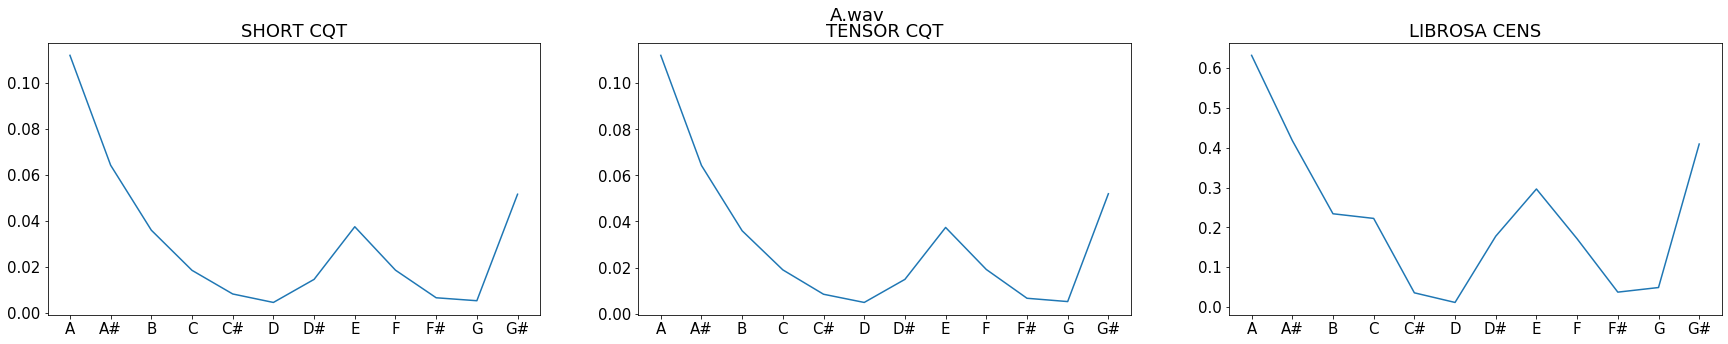

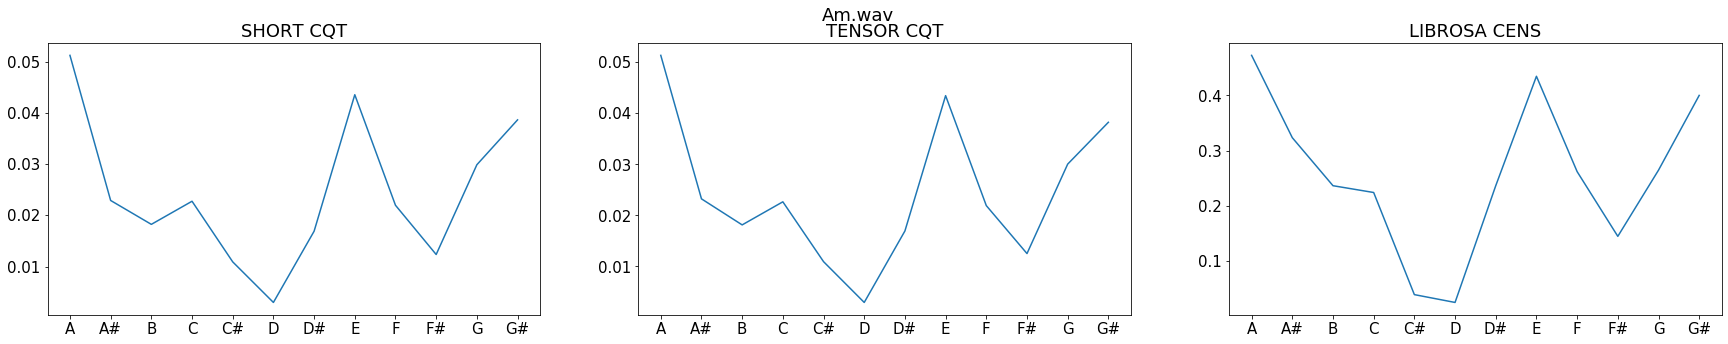

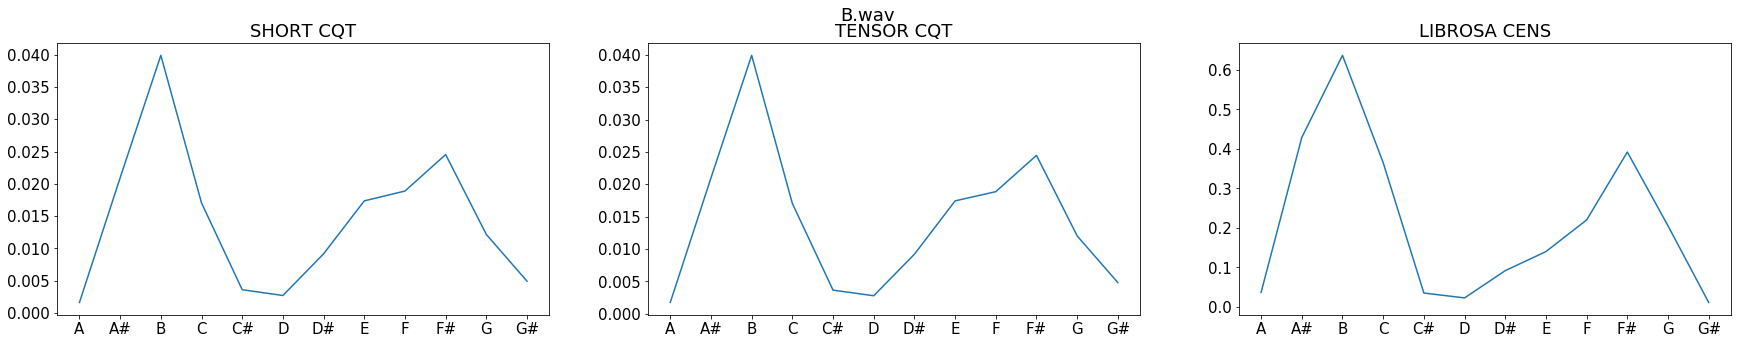

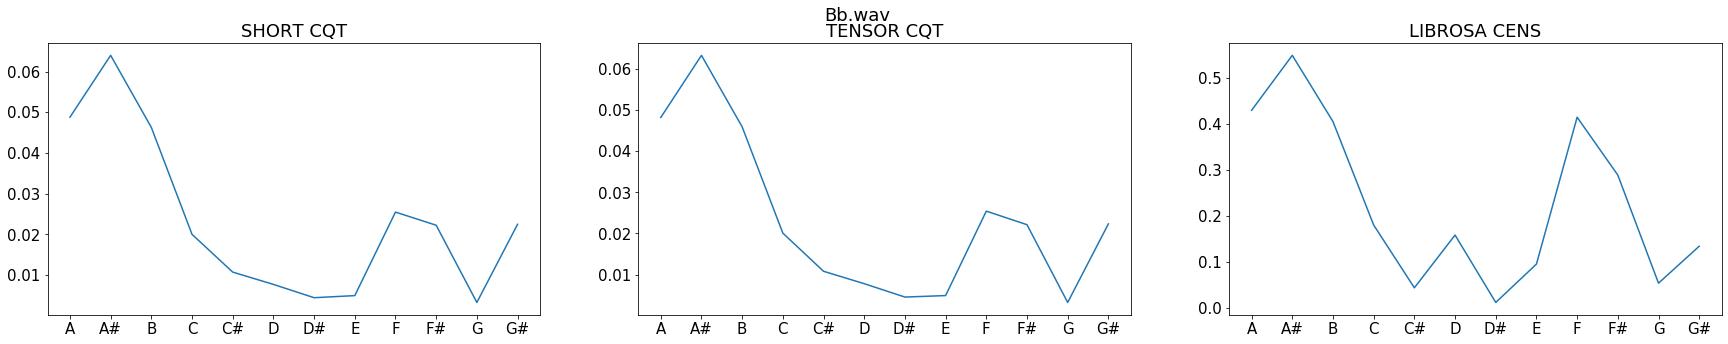

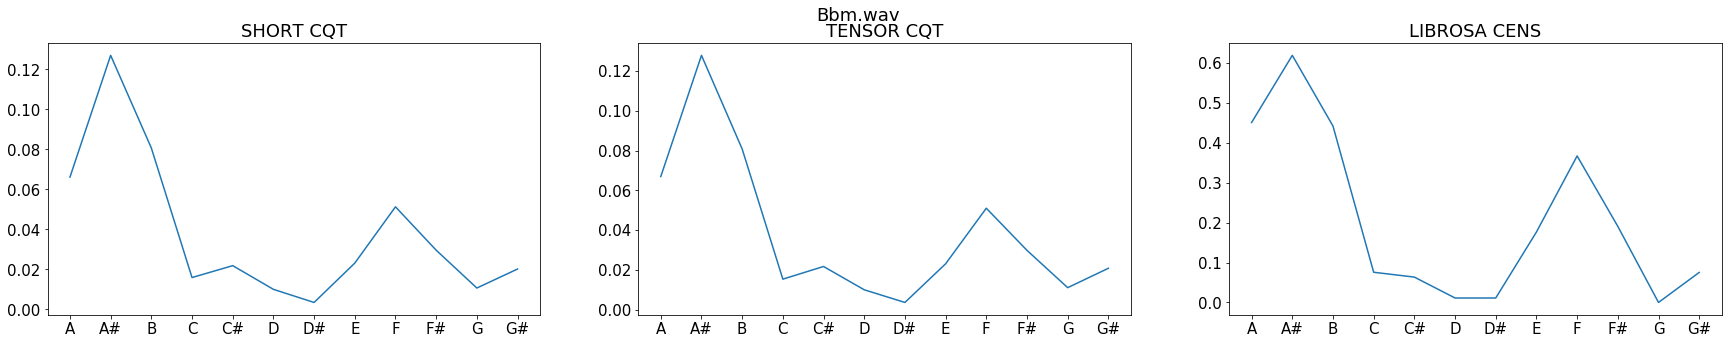

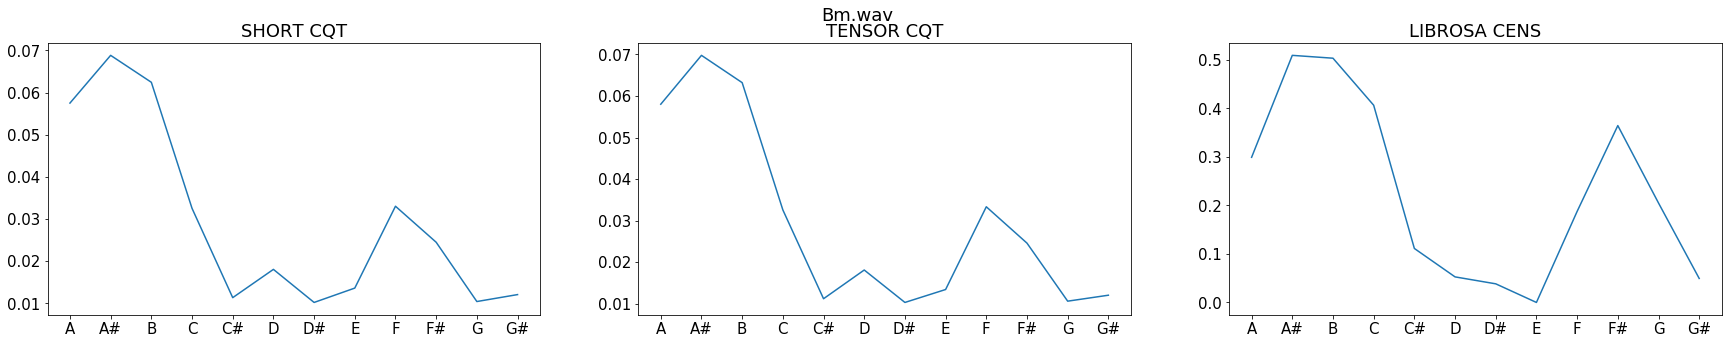

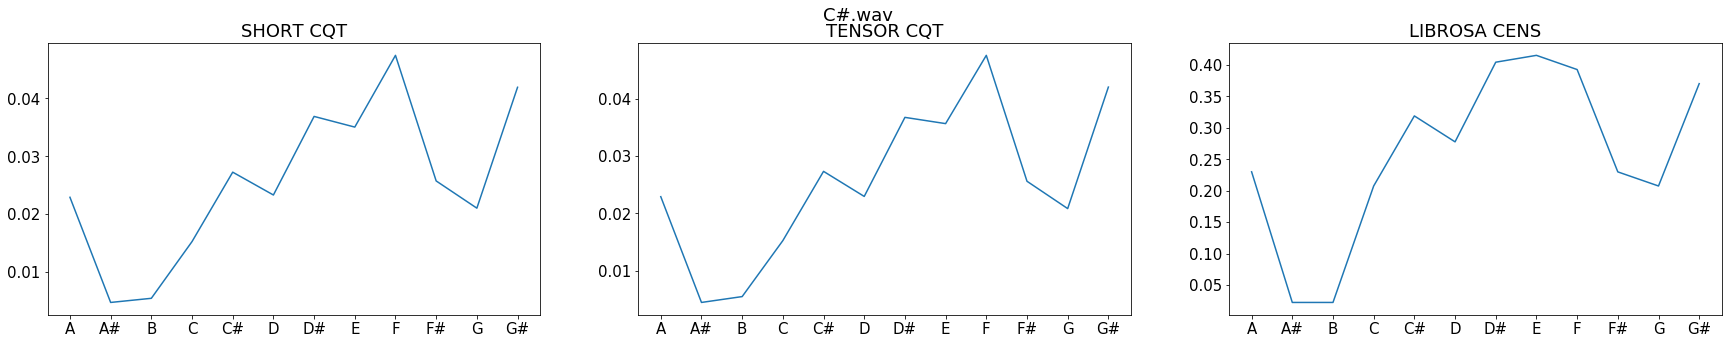

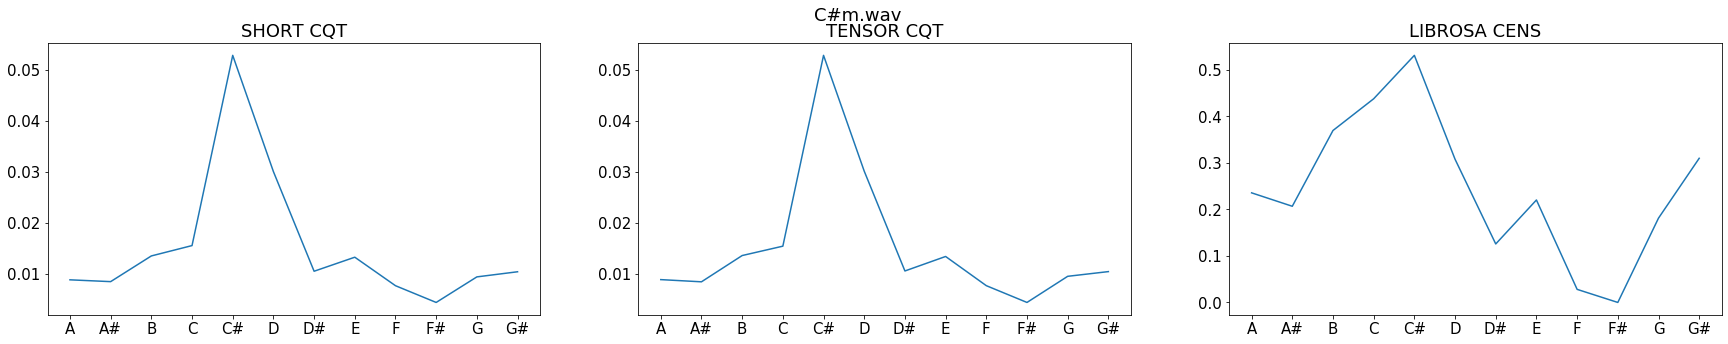

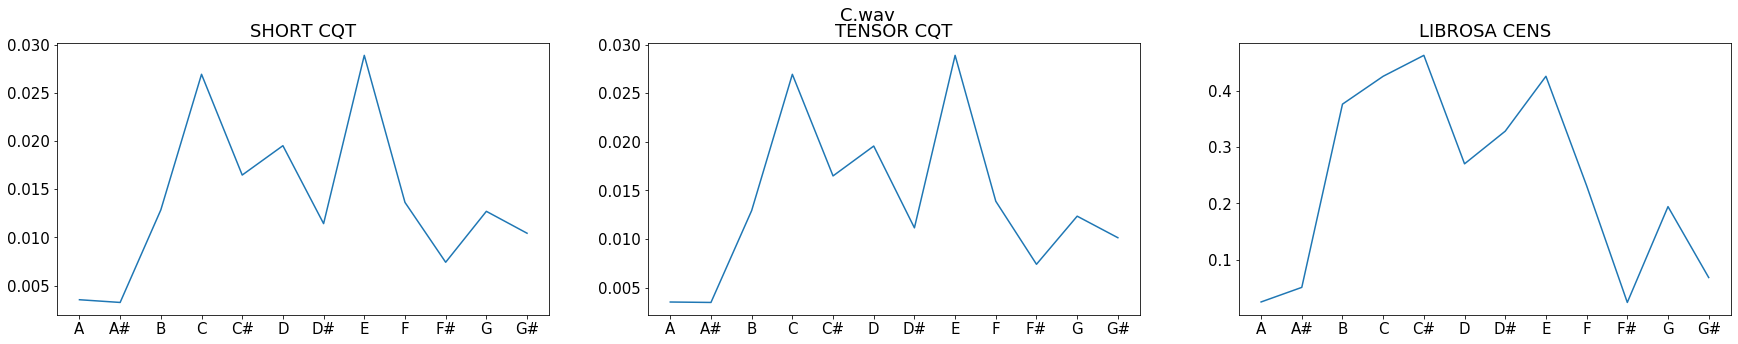

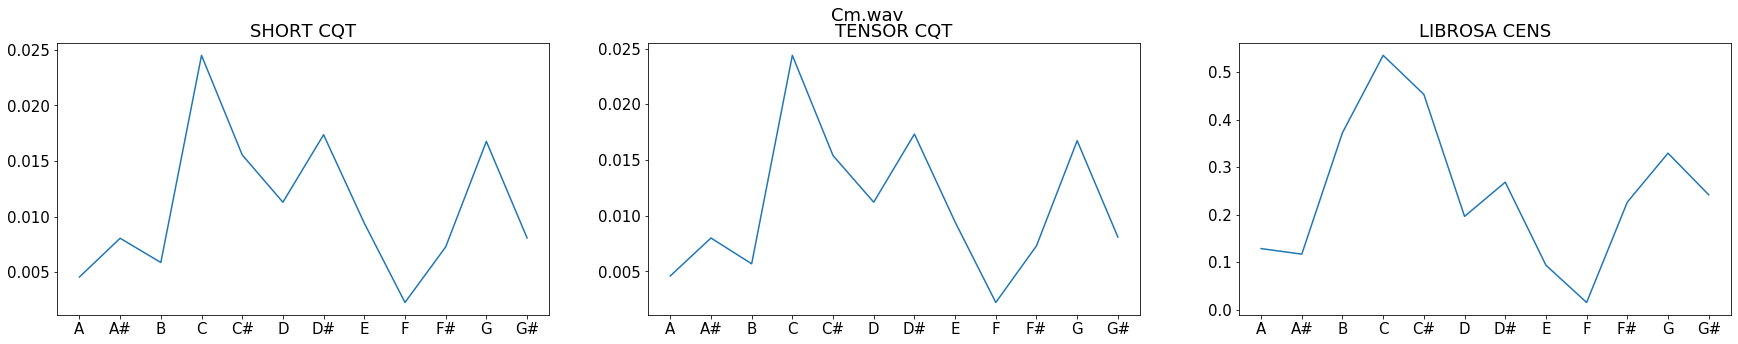

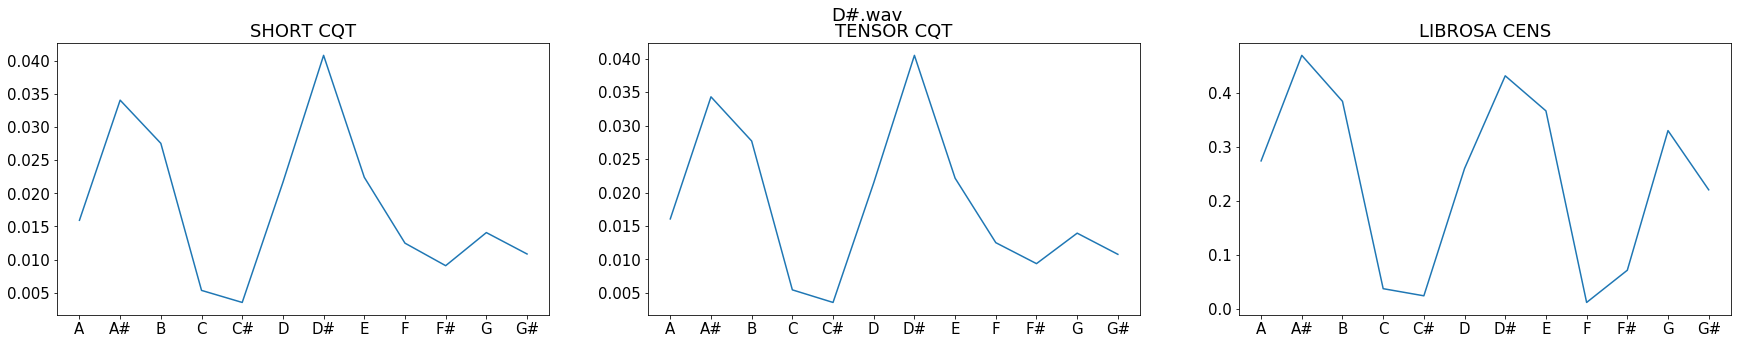

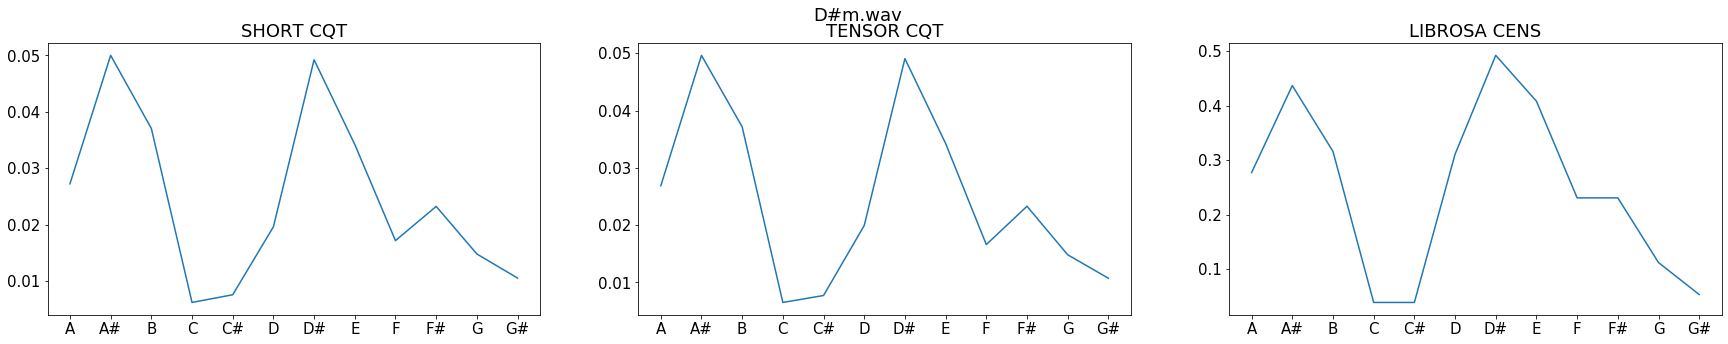

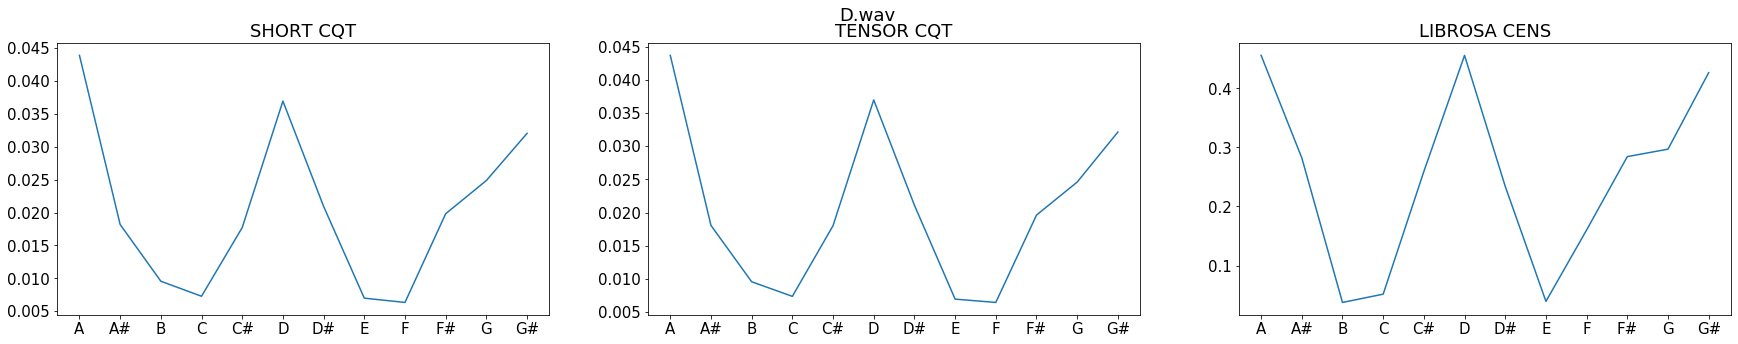

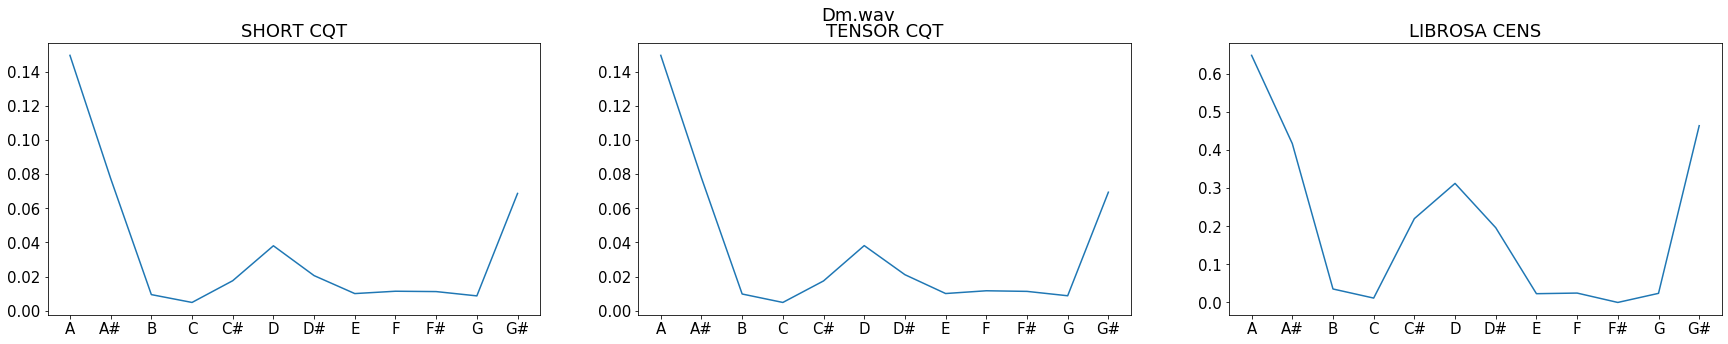

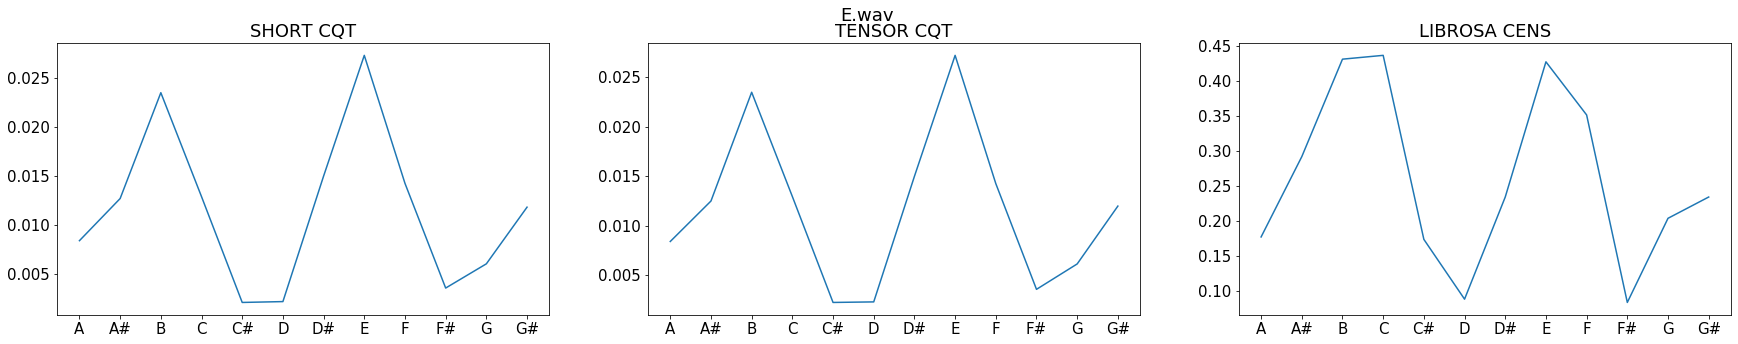

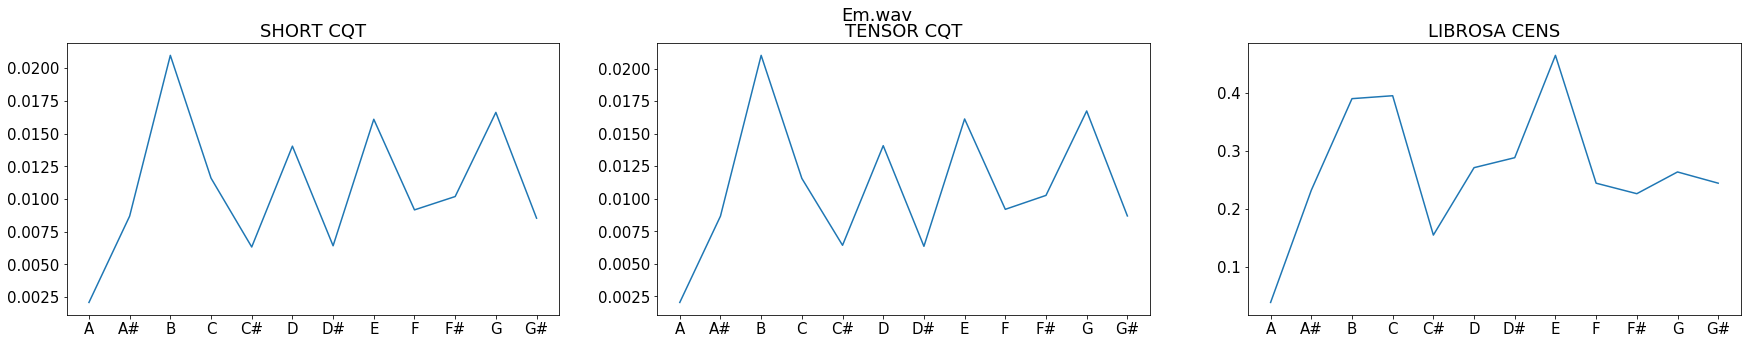

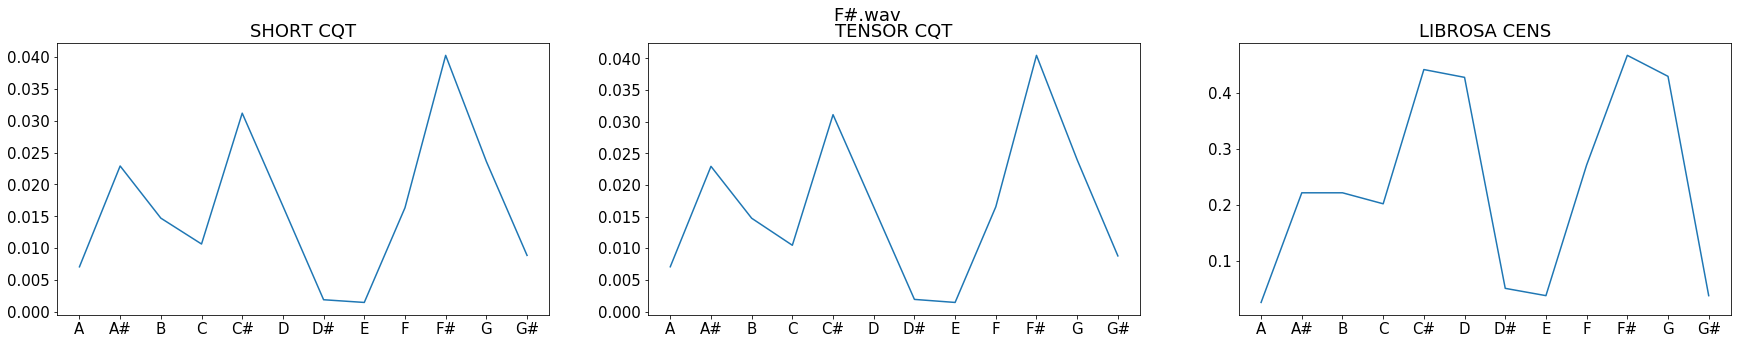

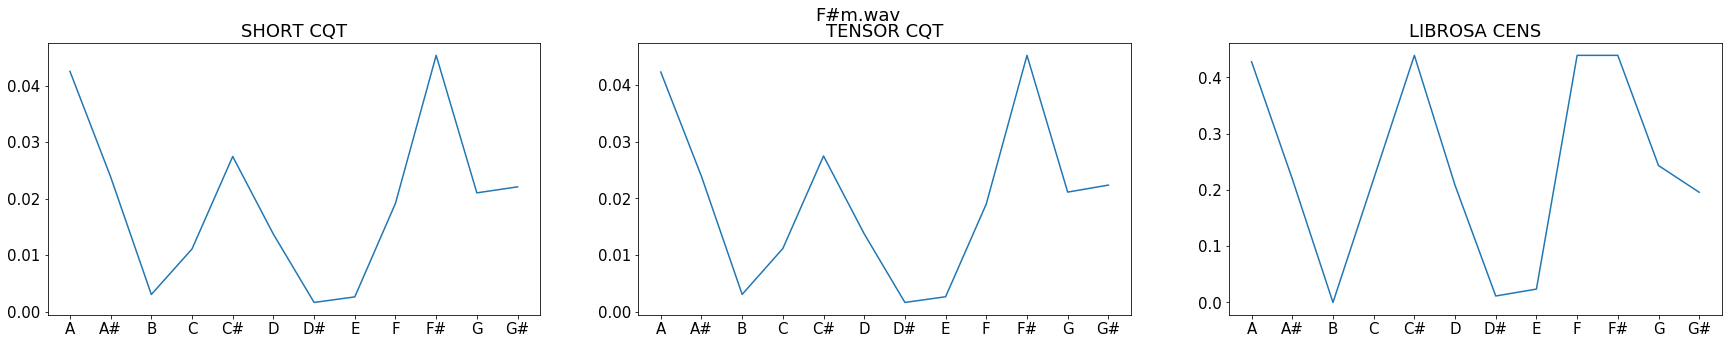

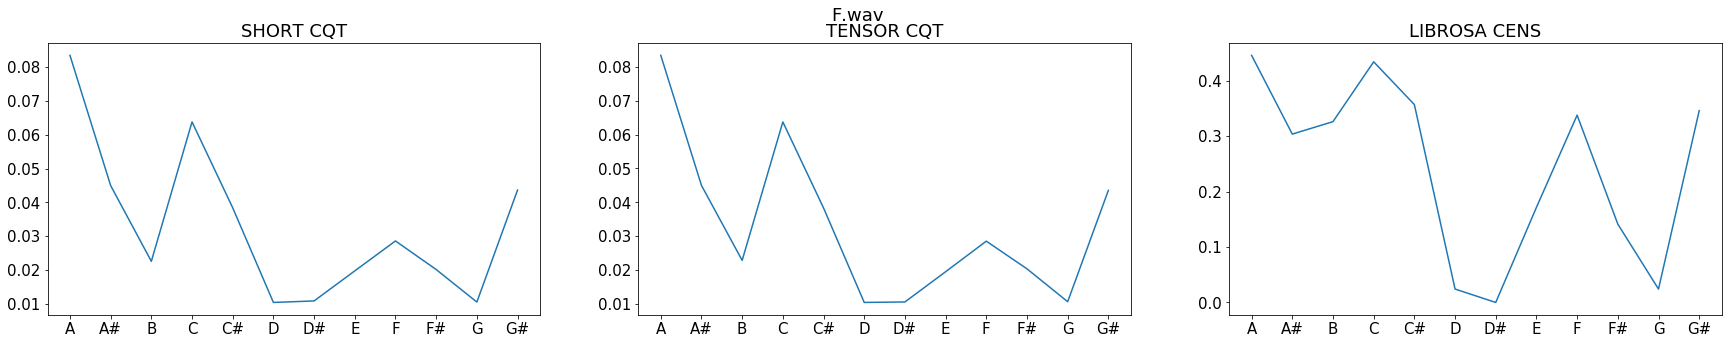

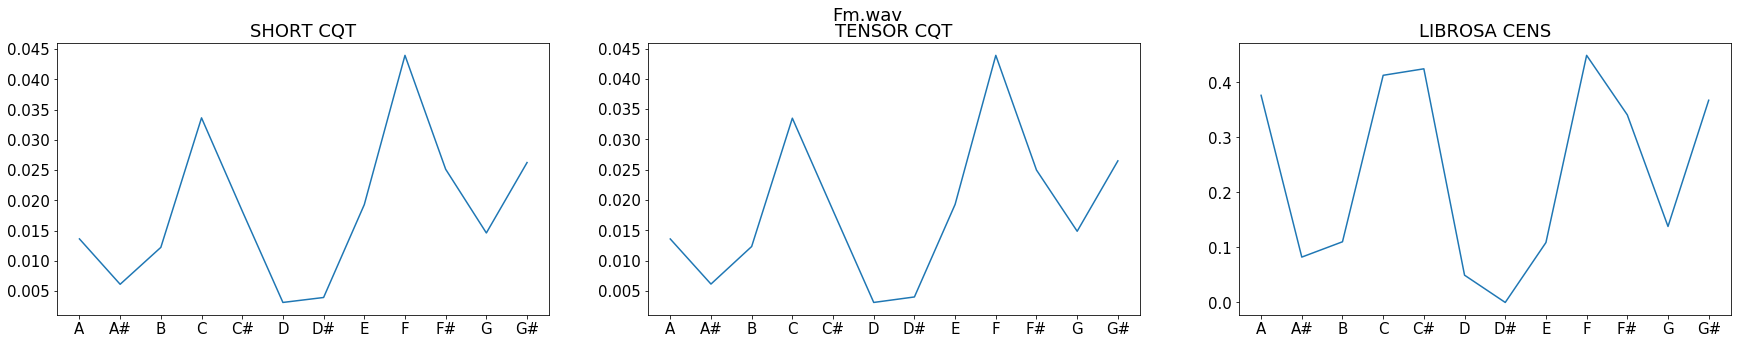

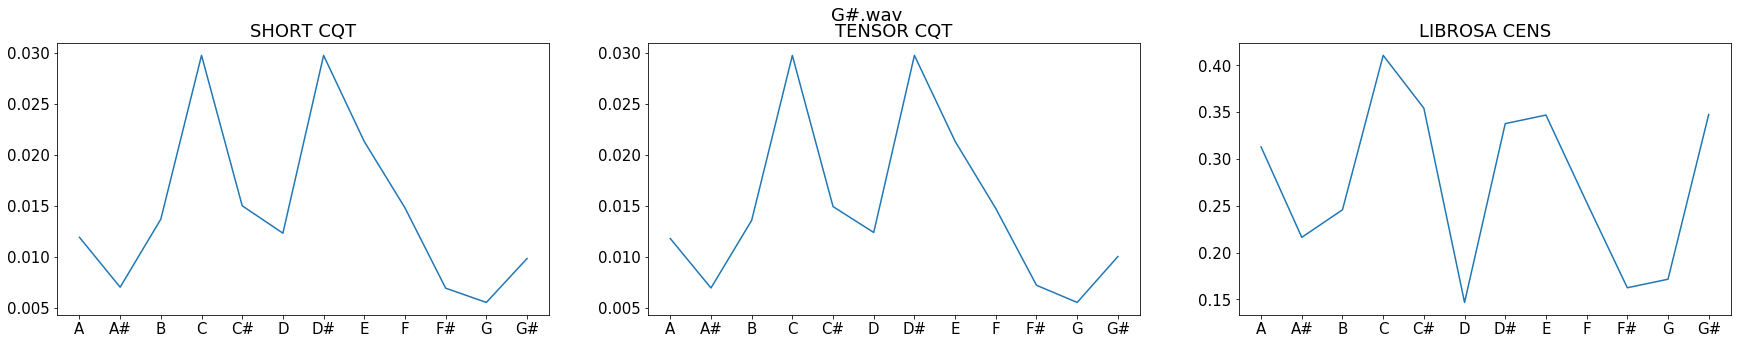

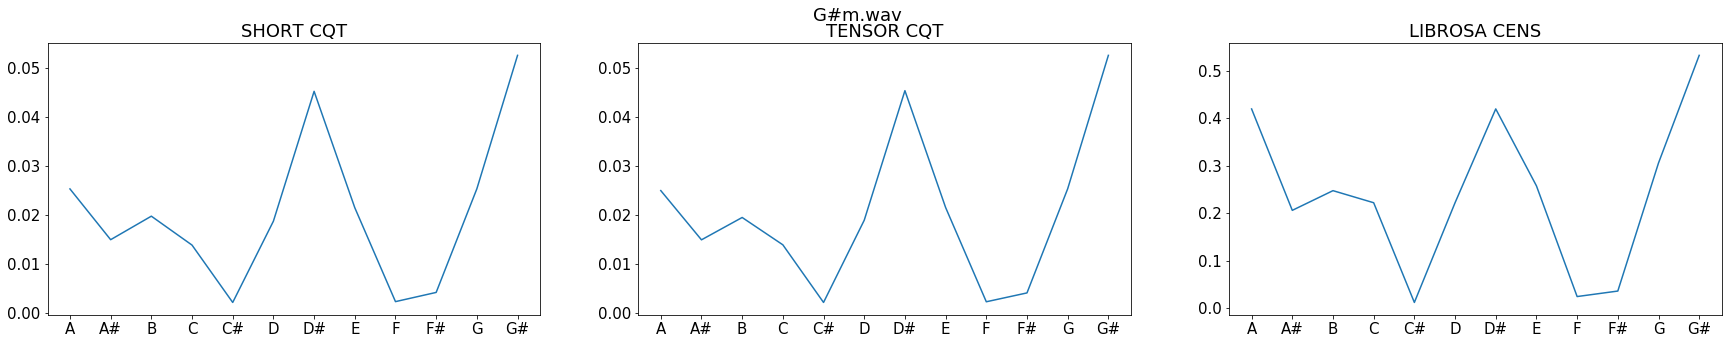

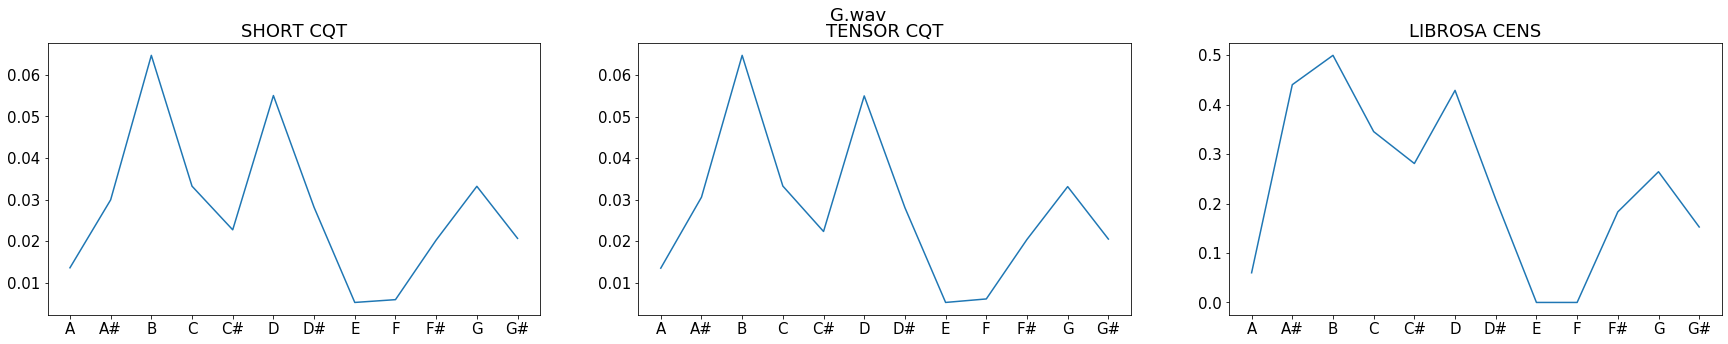

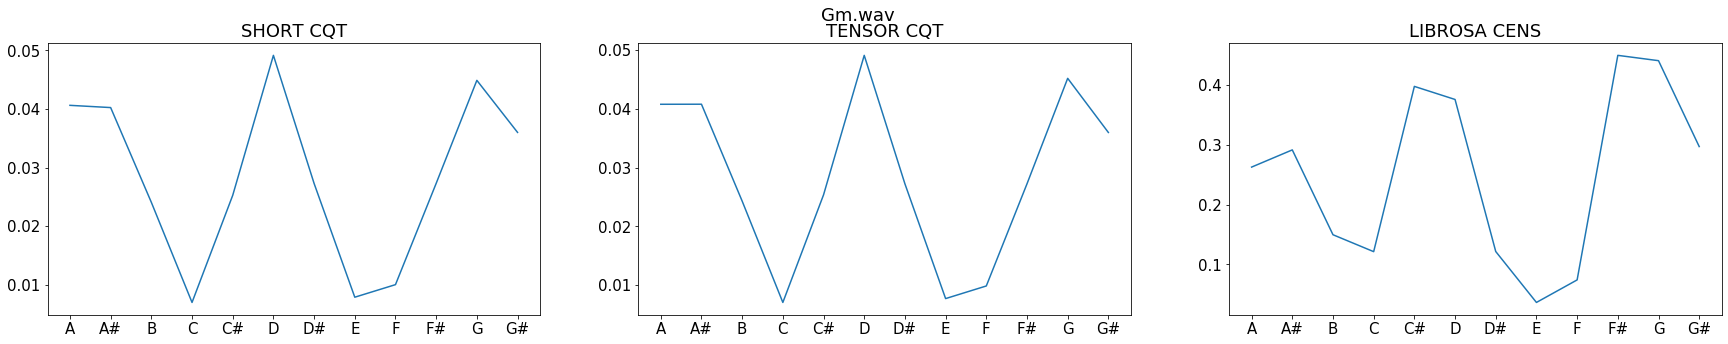

In [218]:
for i in range(len(files)):
    x, sr = librosa.load('./24chords/{}'.format(files[i]), sr=None)

    notes = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    
    plt.figure(figsize=(30, 5))
    plt.suptitle(files[i])
    
    ### SHORT SCIPY CQT ###
    chroma = compute_chroma(x, sample_rate,mode='scipy')
    plt.subplot(1, 3, 1)
    plt.xticks(np.arange(12),notes)
    plt.title('SHORT CQT')
    plt.plot(chroma) # Plot list. x-values assumed to be [0, 1, 2, 3]
    
    ### SHORT TENSOR CQT ###
    chroma = compute_chroma(x, sample_rate,mode='tensor')
    plt.subplot(1, 3, 2)
    plt.xticks(np.arange(12),notes)
    plt.title('TENSOR CQT')
    plt.plot(chroma) # Plot list. x-values assumed to be [0, 1, 2, 3]


    ### LIBROSA CENS #######
    chroma_cens = librosa.feature.chroma_cens(x, sr=sr, hop_length=512)
    chroma_cens = np.mean(chroma_cens,axis=1)
    chroma_cens = np.roll(chroma_cens, 3) ## DISPLAY PURPOSE: start with A instead of C
    plt.subplot(1, 3, 3)
    plt.xticks(np.arange(12),notes)
    plt.title('LIBROSA CENS')
    plt.plot(chroma_cens) # Plot list. x-values assumed to be [0, 1, 2, 3]
    plt.show()

### Appendix: scipy.fftpack.fft to tensorflow.signal.fft equivalents

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(512,)

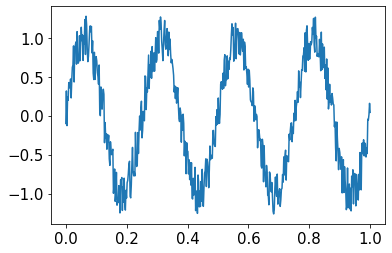

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf

X = np.linspace(0, 1, num=512)
data = np.sin(X * 2 * np.pi * 4) + np.random.uniform(-0.3, 0.3, size=512)
data = data.astype(np.complex64)

plt.plot(X, data)
data.shape

In [35]:
# np_fft = np.fft.fft(data)

sp_fft = scipy.fftpack.fft(data)
# sp_fft = np.r_[sp_fft[:1], sp_fft[1:-1:2] + sp_fft[2:-1:2] * 1j, sp_fft[-1:]]

tf_fft = tf.signal.fft(data)
print(sp_fft.shape)
print(tf_fft.shape)

(512,)
(512,)


In [162]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels and sample rate in Hz
audio_signal, sample_rate = librosa.load('./24chords/Bbm.wav', sr=None)

### SCIPY
from scipy.fftpack import fft
# print(fft(audio_signal, 16384))
print(fft(audio_signal))
print(fft(audio_signal).shape)

import tensorflow as tf
# audio_signal = tf.convert_to_tensor(audio_signal, dtype=tf.complex64)

### TENSORFLOW
# padding = tf.constant([[4112, 4112]])
# audio_signal = tf.pad(audio_signal, padding)
print(tf.signal.fft(audio_signal))
print(tf.signal.fft(audio_signal).shape)

[1.6367493-0.j         1.7088028-0.01084004j 1.9396751-0.48760214j ...
 1.3817152+0.29175135j 1.9396751+0.48760214j 1.7088028+0.01084004j]
(8160,)
tf.Tensor(
[1.6360989-1.1634827e-04j 1.7078263-1.0098888e-02j
 1.9430869-4.8593360e-01j ... 1.3749989+2.9950154e-01j
 1.9395628+4.9330768e-01j 1.7061269+1.4022099e-02j], shape=(8160,), dtype=complex64)
(8160,)


## [Archived] Explore Melspectrograms - not distinct between chords

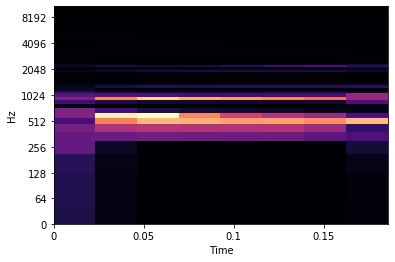

In [75]:
y, sr = librosa.load('./24chords/C#.wav',duration=3)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps, y_axis='log', x_axis='time')

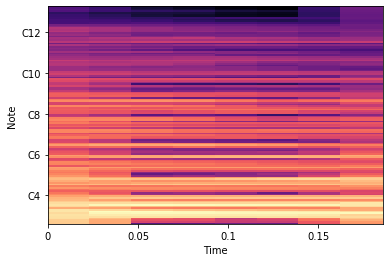

In [76]:
## y Mel, DECIBEL
y, sr = librosa.load('./24chords/C#.wav',duration=3)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps_db= librosa.power_to_db(ps, ref=np.max)

librosa.display.specshow(ps_db, x_axis='time', y_axis='cqt_note', fmin=100)

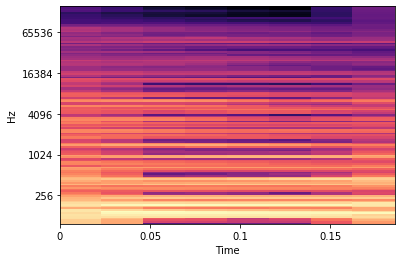

In [77]:
## y Mel, DECIBEL
y, sr = librosa.load('./24chords/C#.wav',duration=3)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps_db= librosa.power_to_db(ps, ref=np.max)

librosa.display.specshow(ps_db, x_axis='time', y_axis='cqt_hz', fmin=100)

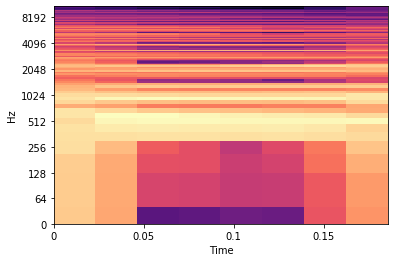

In [78]:
# Y LOG, DECIBEL
y, sr = librosa.load('./24chords/C#.wav')
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps_db= librosa.power_to_db(ps, ref=np.max)

librosa.display.specshow(ps_db, x_axis='time', y_axis='log')

## [Archived] Try 3: Generate chromas without Librosa library - "Long CQT" - Compared with Librosa
 
Tried to use in the Model but a lot of numpy to tensor conversion errors, resulting in the Model being unable to save
adapted from https://github.com/zafarrafii/Z#cqtkernel-constant-q-transform-cqt-kernel

In [16]:
import scipy.io.wavfile
import time

def cqtkernel(sample_rate=48000, frequency_resolution=1, minimum_frequency=55, maximum_frequency=1760):

    # Number of frequency channels per octave
    octave_resolution = 12 * frequency_resolution

    # Constant ratio of frequency to resolution (= fk/(fk+1-fk))
    quality_factor = 1 / (2 ** (1 / octave_resolution) - 1)

    # Number of frequency channels for the CQT
    number_frequencies = int(round(octave_resolution * np.log2(maximum_frequency / minimum_frequency)))

    # Window length for the FFT (= window length of the minimum frequency = longest window)
    fft_length = int(2 ** np.ceil(np.log2(quality_factor * sample_rate / minimum_frequency)))
    
    # Initialize the kernel
    cqt_kernel = np.zeros((number_frequencies, fft_length), dtype=complex)

    # Loop over the frequency channels
    for frequency_index in range(0, number_frequencies):

        # Frequency value (in Hz)
        frequency_value = minimum_frequency * 2 ** (frequency_index / octave_resolution)

        # Window length (nearest odd value because the complex exponential will have an odd length, in samples)
        window_length = 2 * round(quality_factor * sample_rate / frequency_value / 2) + 1

        # Temporal kernel (without zero-padding, odd and symmetric)
        temporal_kernel = np.hamming(window_length) \
            * np.exp(2 * np.pi * 1j * quality_factor
                     * np.arange(-(window_length - 1) / 2, (window_length - 1) / 2 + 1) / window_length) / window_length

        # Pre zero-padding to center FFTs (fft does post zero-padding; temporal kernel still odd but almost symmetric)
        temporal_kernel = np.pad(temporal_kernel, (int((fft_length - window_length + 1) / 2), 0),
                                 'constant', constant_values=0)

        # Spectral kernel (mostly real because temporal kernel almost symmetric)
        spectral_kernel = np.fft.fft(temporal_kernel, fft_length)

        # Save the spectral kernels
        cqt_kernel[frequency_index, :] = spectral_kernel

    # Energy threshold for making the kernel sparse
    energy_threshold = 0.01

    # Make the CQT kernel sparser
    cqt_kernel[np.absolute(cqt_kernel) < energy_threshold] = 0

    # Make the CQT kernel sparse
#     print('CQT SHAPE ', cqt_kernel.shape)
    cqt_kernel = scipy.sparse.csc_matrix(cqt_kernel)
#     print('CQT SHAPE SPARSE ', cqt_kernel.shape)

    # From Parseval's theorem
    cqt_kernel = np.conjugate(cqt_kernel) / fft_length

    return cqt_kernel


def cqtspectrogram(audio_signal, cqt_kernel, sample_rate=48000, time_resolution=10):

    # Number of time samples per time frame
    step_length = round(sample_rate / time_resolution)

    # Number of time frames
    number_times = int(np.floor(audio_signal.shape[0] / step_length))

    # Number of frequency channels and FFT length
    number_frequencies, fft_length = np.shape(cqt_kernel)
    
#     print(fft_length, step_length)

    # Zero-padding to center the CQT
    audio_signal = np.pad(audio_signal, (int(np.ceil((fft_length - step_length) / 2)),
                                         int(np.floor((fft_length - step_length) / 2))), 'constant',
                          constant_values=(0, 0))
    
#     print('after pad ', audio_signal.shape)

    # Initialize the spectrogram
    audio_spectrogram = np.zeros((number_frequencies, number_times))
    
#     print('spectrogram ', audio_spectrogram.shape)

    # Loop over the time frames
    for time_index in range(0, number_times):

        # Magnitude CQT using the kernel
        sample_index = time_index * step_length
        
#         print('audio_signal ', audio_signal.shape)
        
        test = audio_signal[sample_index:sample_index + fft_length]
#         print('audio_signal[] ', test)
#         print('audio_signal[] ', test.shape)
#         print('fft ', np.fft.fft(test))
#         print('fft ', np.fft.fft(test).shape)
#         print('cqt ', cqt_kernel.shape)
#         print('cqt * fft ', (cqt_kernel * np.fft.fft(audio_signal[sample_index:sample_index + fft_length])).shape)
#         print('abs ', (abs(cqt_kernel * np.fft.fft(audio_signal[sample_index:sample_index + fft_length]))).shape)
        
        audio_spectrogram[:, time_index] \
            = abs(cqt_kernel * np.fft.fft(audio_signal[sample_index:sample_index + fft_length]))

    return audio_spectrogram


def cqtchromagram(audio_signal, sample_rate=48000, time_resolution=10, frequency_resolution=1):
    
    # CQT Kernel
    cqt_kernel = cqtkernel(sample_rate, frequency_resolution)

    # CQT spectrogram
    audio_spectrogram = cqtspectrogram(audio_signal, cqt_kernel)

    # Number of frequency channels and time frames
    number_frequencies, number_times = np.shape(audio_spectrogram)

    # Number of chroma bins
    number_chromas = 12 * frequency_resolution

    # Initialize the chromagram
    audio_chromagram = np.zeros((number_chromas, number_times))

    # Loop over the chroma bins
    for chroma_index in range(0, number_chromas):

        # Sum the energy of the frequency channels for every chroma
        audio_chromagram[chroma_index, :] \
            = np.sum(audio_spectrogram[chroma_index:number_frequencies:number_chromas, :], 0)
    return audio_chromagram

### Get Chroma for one chord (Bbm)

In [17]:
%matplotlib inline

# Import modules
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels and sample rate in Hz
audio_signal, sample_rate = librosa.load('./24chords/Bbm.wav', sr=None)

# CQT chromagram
time_resolution = 5
audio_chromagram = cqtchromagram(audio_signal)
audio_chromagram

array([[0.0452346 ],
       [0.08636416],
       [0.07392882],
       [0.01608943],
       [0.02312371],
       [0.01001624],
       [0.00459629],
       [0.02051118],
       [0.05069917],
       [0.02969926],
       [0.01236622],
       [0.01818314]])

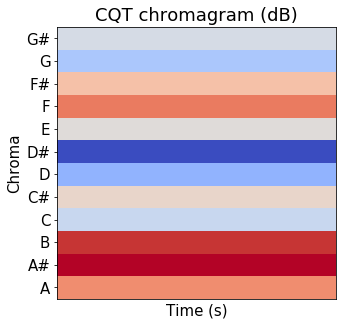

In [18]:
# CQT chromagram displayed in dB, s, and chromas

frequency_resolution = 1

plt.figure(figsize=(5,5))
plt.rc('font', size=15)
plt.imshow(20*np.log10(audio_chromagram), aspect='auto', cmap='coolwarm', origin='lower')
plt.title('CQT chromagram (dB)')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*time_resolution),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.yticks(np.arange(0, 12*frequency_resolution, frequency_resolution),
           ('A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'))
plt.ylabel('Chroma')
plt.show()

### Check that Long CQT works for all chords. Compare with librosa.chroma_cens
Conclusion: "Long CQT" is pretty accurate. Note that for the y-axis, long CQT starts at A vs Librosa starts at C

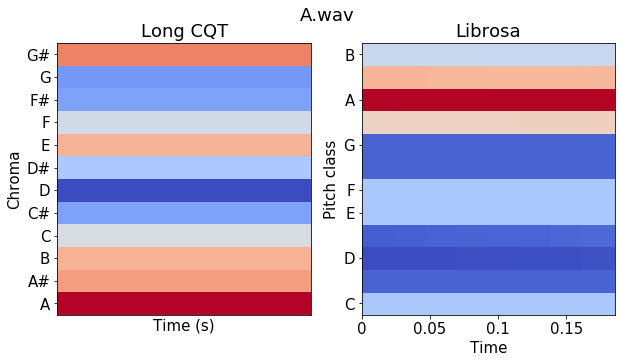

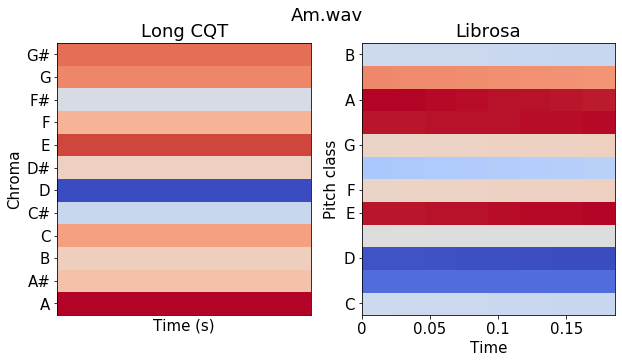

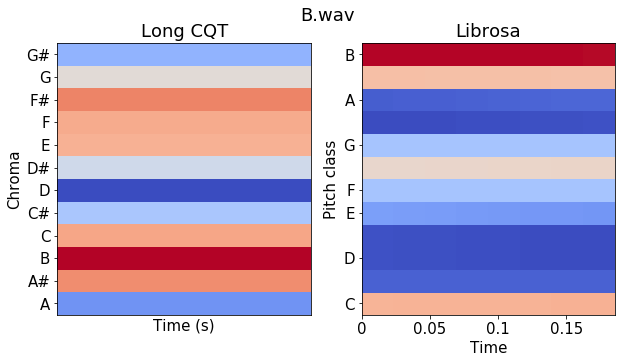

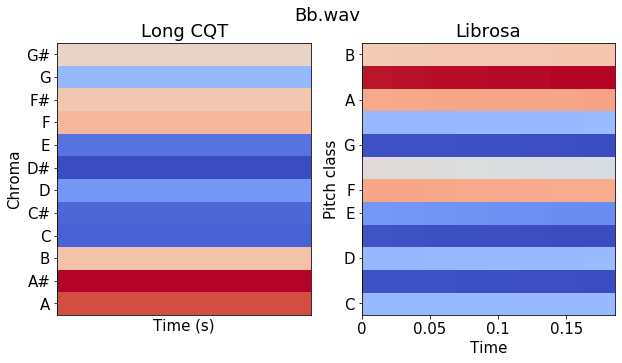

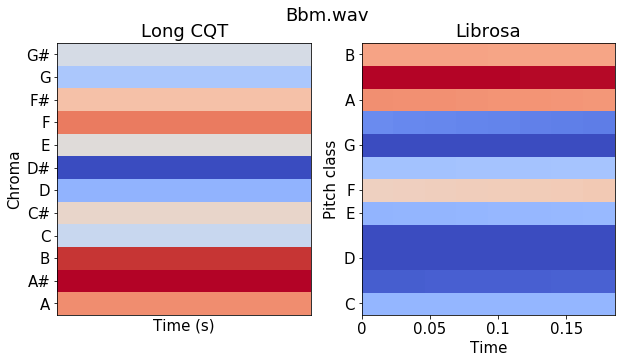

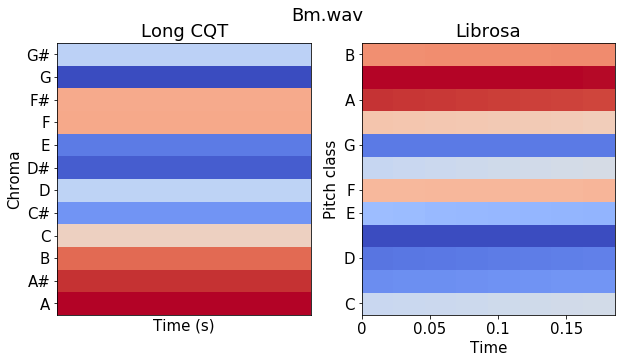

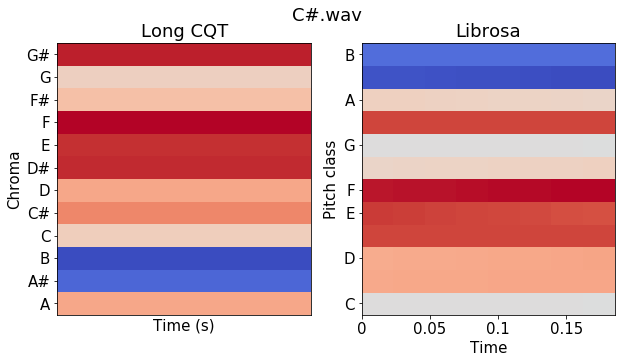

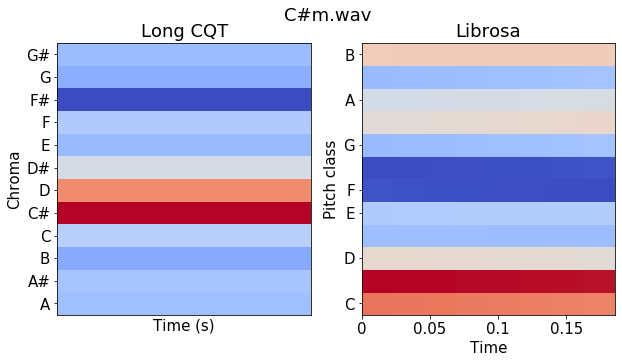

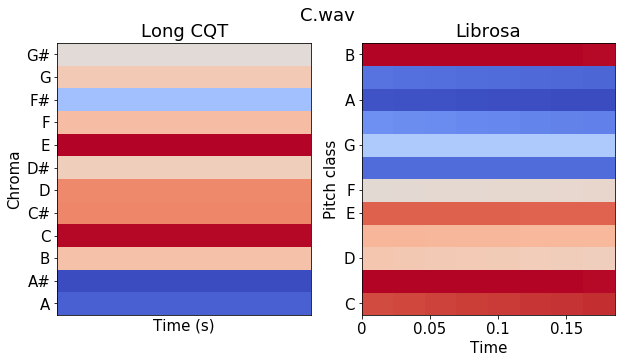

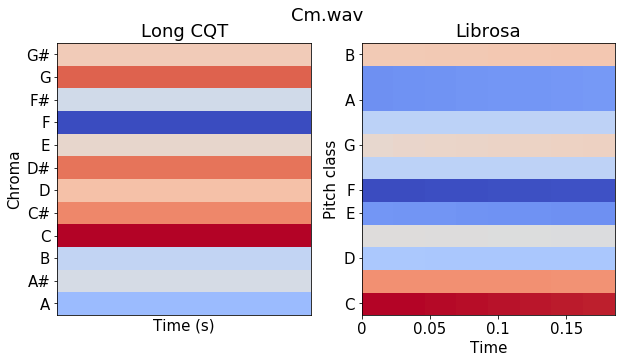

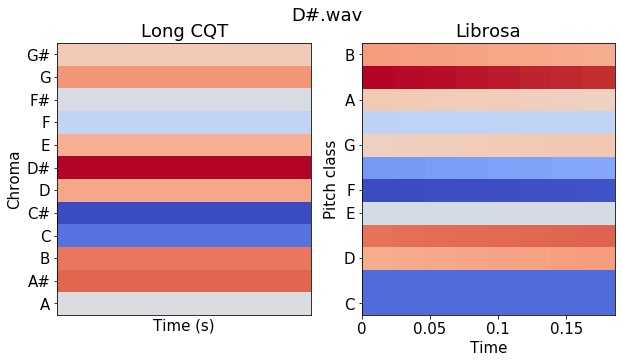

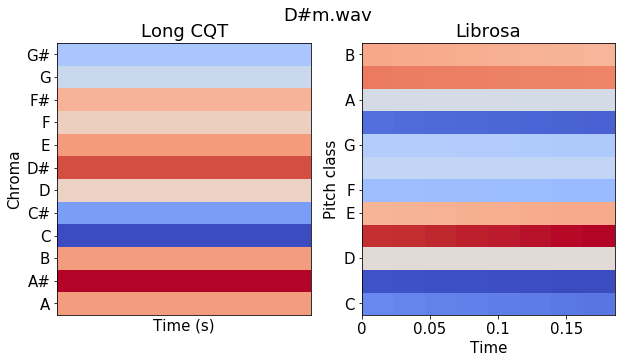

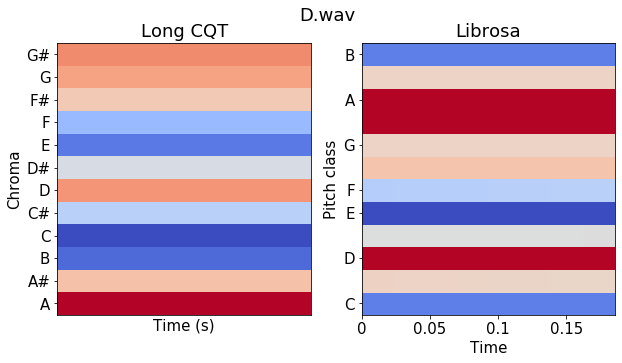

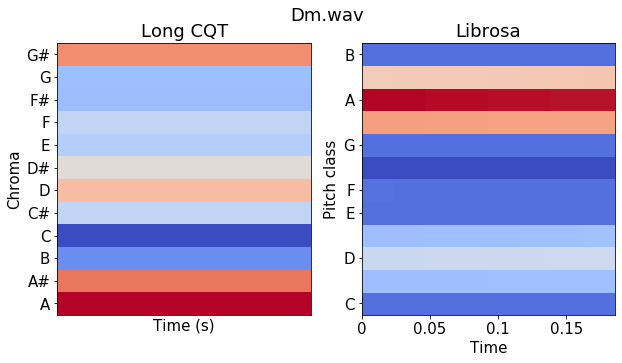

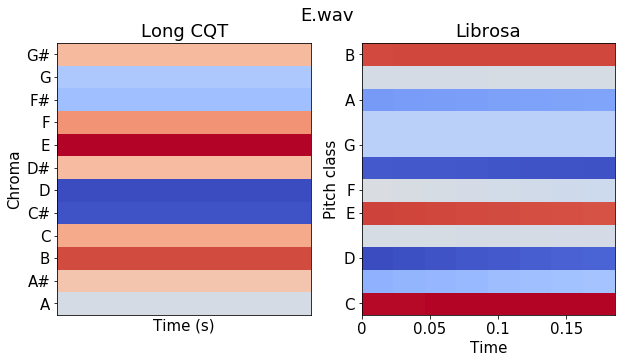

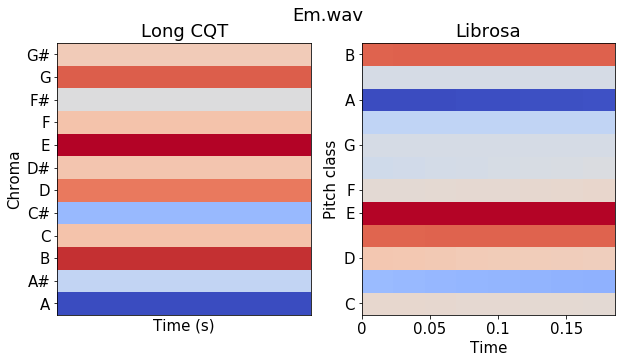

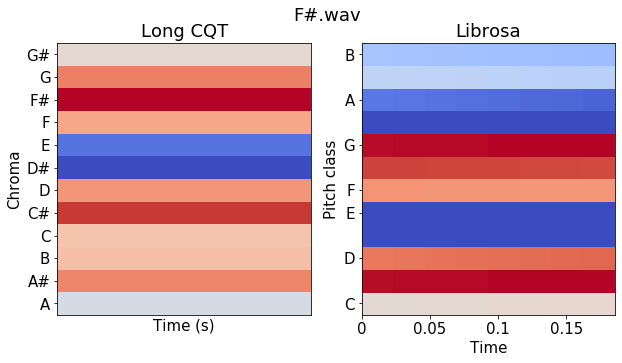

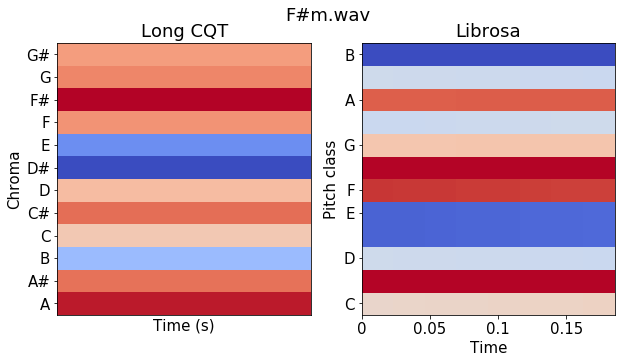

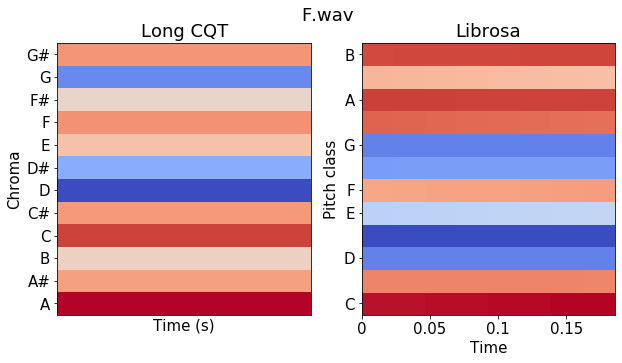

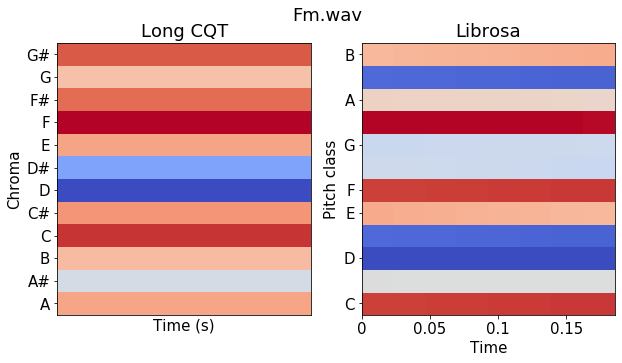

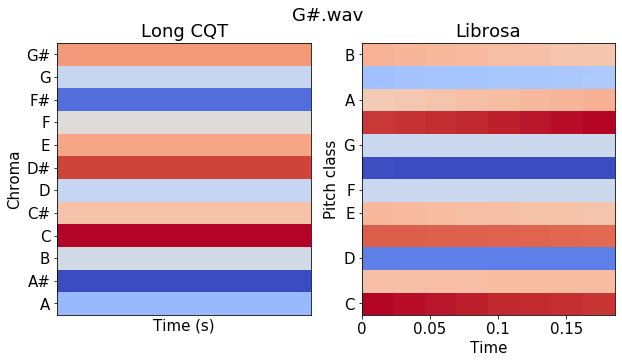

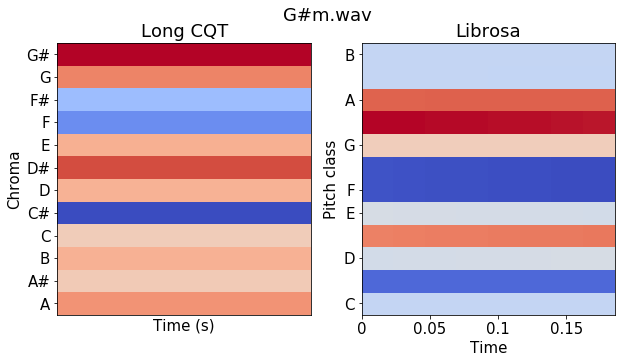

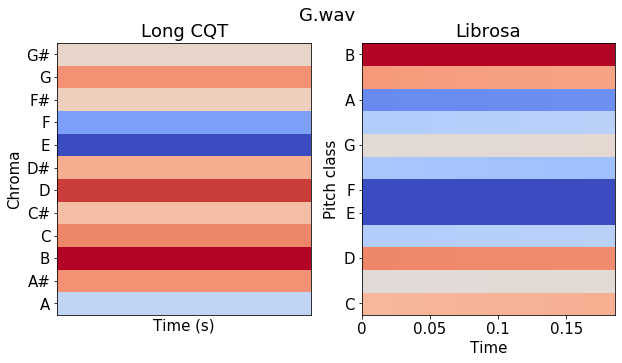

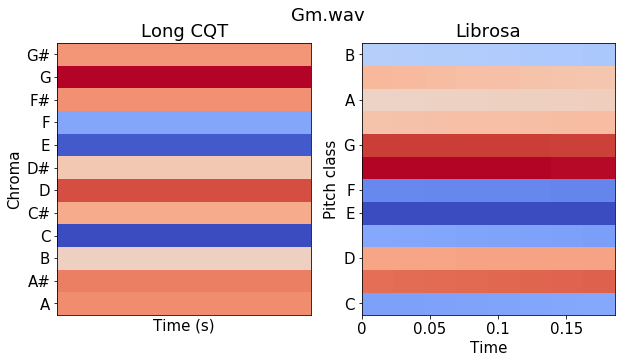

In [19]:
# Audio signal (normalized) averaged over its channels and sample rate in Hz
import os
import librosa

path = './24chords/'
files = list(os.listdir(path))
files.sort()
   
# CQT kernel
frequency_resolution = 1
minimum_frequency = 55
maximum_frequency = 1760
time_resolution = 10
cqt_kernel = cqtkernel(sample_rate, frequency_resolution, minimum_frequency, maximum_frequency)
    
for i in range(len(files)):
    
    audio_signal, sr = librosa.load('./24chords/{}'.format(files[i]), sr=None)

    # CQT chromagram
    audio_chromagram = cqtchromagram(audio_signal)
    
    plt.figure(figsize=(10, 5))
    plt.rc('font', size=15)
    
    
    plt.subplot(1, 2, 1)
    plt.imshow(20*np.log10(audio_chromagram), aspect='auto', cmap='coolwarm', origin='lower')
    plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*time_resolution),
               np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
    plt.xlabel('Time (s)')
    plt.yticks(np.arange(0, 12*frequency_resolution, frequency_resolution),
               ('A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'))
    plt.ylabel('Chroma')
    plt.title('Long CQT')
    
    ## COMPARE WITH LIBROSA
    x, sr = librosa.load('./24chords/{}'.format(files[i]))
    cens = librosa.feature.chroma_cens(x, sr=sr, hop_length=512)
    plt.subplot(1, 2, 2)
    plt.title('Librosa')
    librosa.display.specshow(cens, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    
    plt.suptitle(files[i])
    plt.show()